# Week 10: Batch Normalization

This week we discussed batch normalization where inputs to hidden layers in the model are normalized to provide a speed-up in training. Here we will be training a simple MNIST classifier and comparing a plain network to one with batch normalization to demonstrate the training speed-up and visualize some of the effects of BatchNorm on the neural network during training.

In [1]:
# Load the libraries and mnist data
import torch
from torch import nn
from torch import optim
import numpy as np
import seaborn as sns  # might need to install this one first
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from pathlib import Path

%matplotlib notebook

if("dataset" not in globals()):
    root_dir = Path().resolve()
    dataset = torchvision.datasets.MNIST(root_dir, download=True, transform=transforms.ToTensor())
    trainset, testset = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

/home/sean/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Let's see what some of our data looks like by plotting some of the MNIST images and the distribution of their pixels.

Image1 Size: (1, 28, 28)


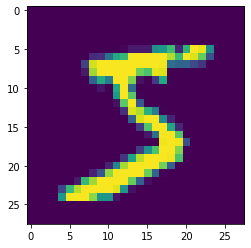

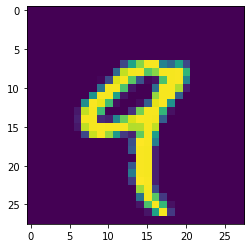

In [2]:
# plot some images
%matplotlib inline
img1 = dataset[0][0]
print("Image1 Size:", tuple(img1.shape))
new_img1 = img1.reshape(28,28)

img2 = dataset[4][0]
new_img2 = img2.reshape(28,28)

plt.figure()
plt.imshow(new_img1)
plt.figure()
plt.imshow(new_img2)

Text(0.5, 1.0, 'distribution of pixels (img2)')

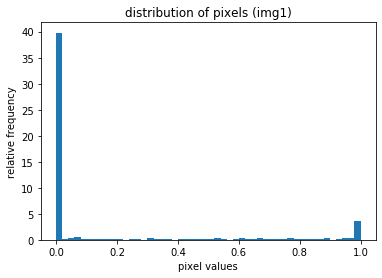

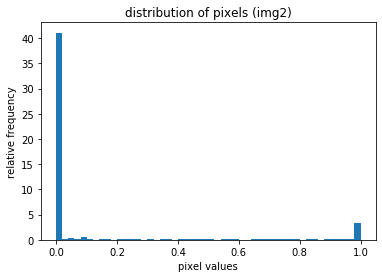

In [3]:
# convert image to numpy array
img_np1 = np.array(new_img1) 
# plot the pixel values
plt.figure()
plt.hist(img_np1.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels (img1)")

# convert image to numpy array
img_np2 = np.array(new_img2) 
# plot the pixel values
plt.figure()
plt.hist(img_np2.ravel(), bins=50, density=True)
plt.xlabel("pixel values")
plt.ylabel("relative frequency")
plt.title("distribution of pixels (img2)")

In [4]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cpu


In [5]:
# Create a test and training set
batch_size = 60

to_device = lambda a: a.to(device)

testloader = torch.utils.data.DataLoader(testset, batch_size, shuffle=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True)

In [6]:
# Used later to view hidden layer activations
class ActivationTracker(nn.Module):
    '''keeps track of the current activation'''
    def __init__(self):
        super(ActivationTracker, self).__init__()

        # Keep track of [0.15, 0.5, 0.85] percentiles
        self.percents_activation_track = torch.tensor([0.15, 0.50, 0.85]).to(device)
        self.all_percents_activation = []

    def get_all_activations(self):
        return np.array(self.all_percents_activation)
        
    def forward(self, x):
        # track activations of the first node
        percents_activation = torch.quantile(x.detach()[:,0], self.percents_activation_track)
        self.all_percents_activation.append(percents_activation.cpu().detach().numpy())
        return x

In [7]:
#initialize linear layer weights with a gaussian as done in the paper
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.normal_(m.weight,0, 0.1)
        m.bias.data.fill_(0.01)

In [19]:
# Create a basic network
class VanillaNN(nn.Module):
    def __init__(self): 
        super(VanillaNN, self).__init__()
        self.classifier = nn.Sequential(
            # TODO: what should the input dim be? Hint: size of img data
            nn.Linear(28*28, 48),  # layer 1
            nn.ReLU(),
            nn.Linear(48, 24),  # layer 2
            ActivationTracker(),
            nn.ReLU(),
            # TODO: output dim
            nn.Linear(24, 10)  # output
        )
        
        #option to use the architecture from the paper instead, but it's slower
        # self.classifier = nn.Sequential(
        #     nn.Linear(None,100),
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     ActivationTracker(),
        #     nn.Sigmoid(),
        #     nn.Linear(100,None)
        # )
        # self.classifier.apply(init_weights)
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def get_model(self):
        return self.classifier

In [20]:
# Using the same structure of the basic network as above, add batch normalization to the input layers
class BatchNormNN(nn.Module):
    def __init__(self): 
        super(BatchNormNN, self).__init__()
        self.classifier = nn.Sequential(
            #TODO: what should the input dim be? Hint: size of img data
            nn.Linear(28*28, 48),   # layer 1
            # TODO: Add batch norm layers before each activation -> nn.BatchNorm1d(size)
            
            nn.BatchNorm1d(48),
            nn.ReLU(),
            nn.Linear(48, 24),  # layer 2
            
            nn.BatchNorm1d(24),
            ActivationTracker(),
            nn.ReLU(),
            # TODO: output dim
            nn.Linear(24, 10)  # output
        )
        
        
        #option to use the architecture from the paper instead, but it's slower
        # self.classifier = nn.Sequential(
        #     nn.Linear(None,100),
        #     
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     
        #     nn.Sigmoid(),
        #     nn.Linear(100,100),
        #     
        #     ActivationTracker(),
        #     nn.Sigmoid(),
        #     nn.Linear(100,None)
        # )
        # self.classifier.apply(init_weights)
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def get_model(self):
        return self.classifier

In [10]:
# Used to get the accuracy of a given model
def get_accuracy(model, data):
        run = 0
        correct = 0
        
        for img, label in data:
            run += len(img)
            result = model.forward(img.to(device)).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

Now that we have our data and models defined, let's train both models using the same parameters and compare their loss over time.

In [11]:
# Start here to train the models
model = VanillaNN().to(device)
print(model)
model_bn = BatchNormNN().to(device)
print(model_bn)

loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=0.01)
opt_bn = optim.SGD(model_bn.parameters(), lr=0.01)

VanillaNN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=24, bias=True)
    (3): ActivationTracker()
    (4): ReLU()
    (5): Linear(in_features=24, out_features=10, bias=True)
  )
)
BatchNormNN(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=48, out_features=24, bias=True)
    (4): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ActivationTracker()
    (6): ReLU()
    (7): Linear(in_features=24, out_features=10, bias=True)
  )
)


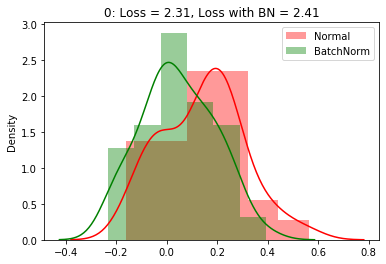

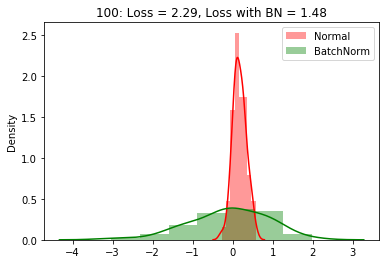

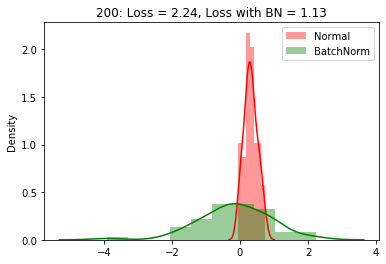

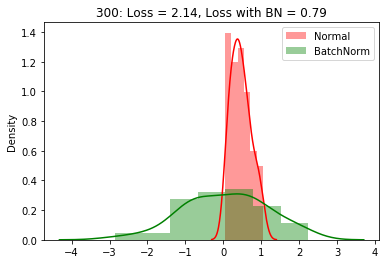

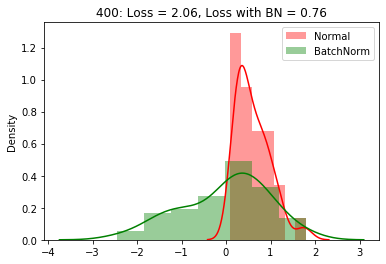

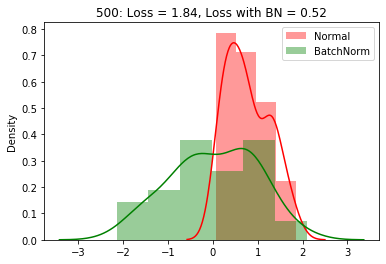

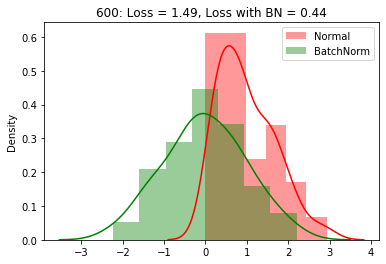

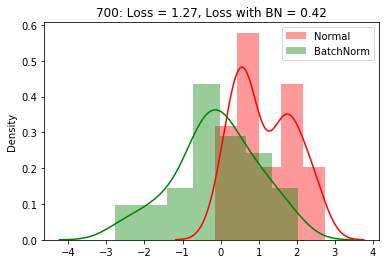

----------------------
0


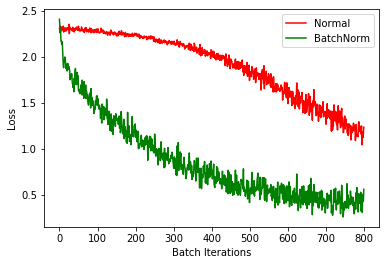

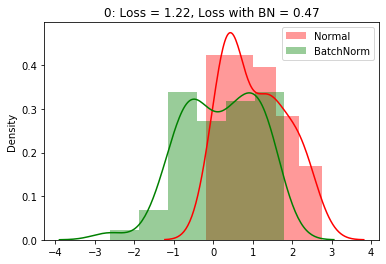

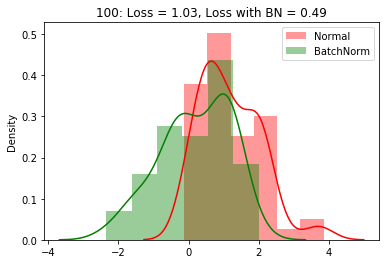

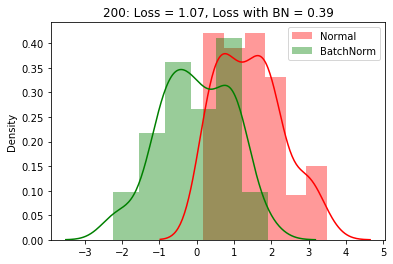

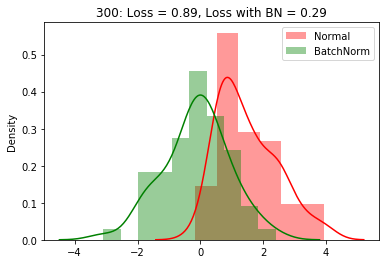

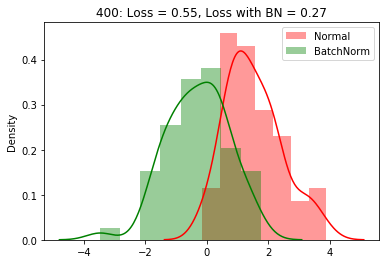

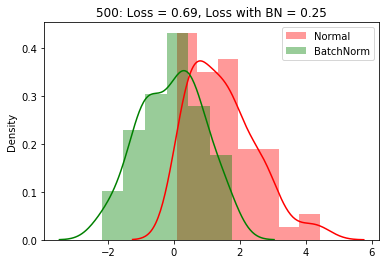

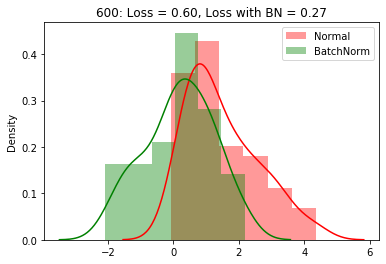

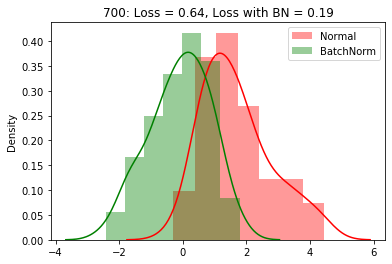

----------------------
1


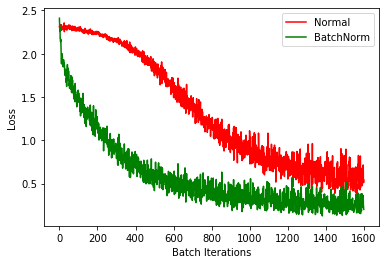

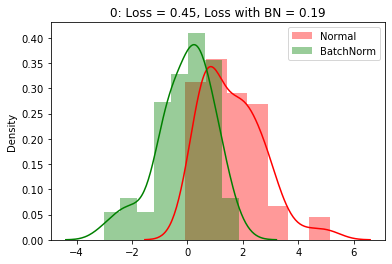

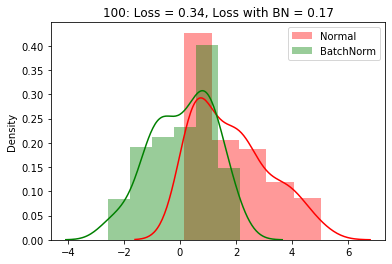

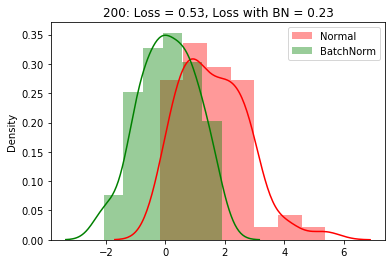

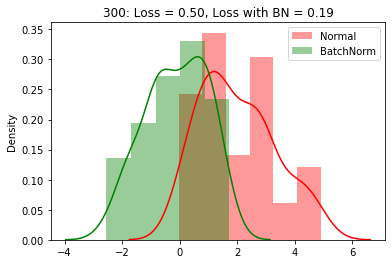

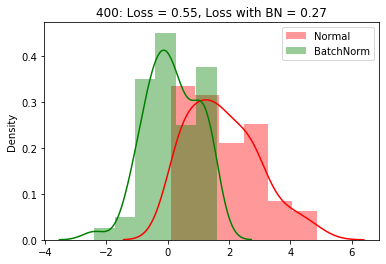

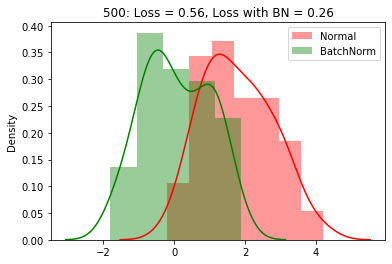

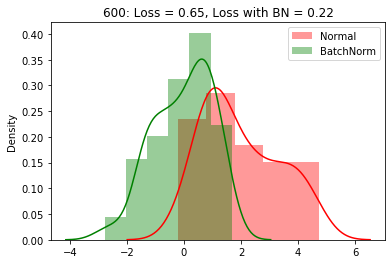

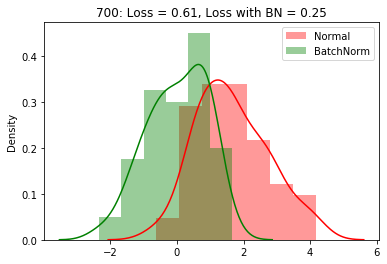

----------------------
2


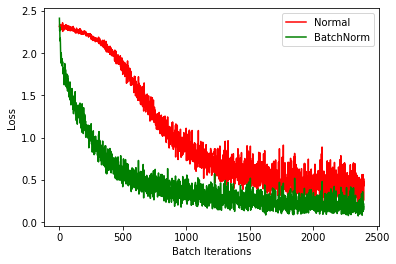

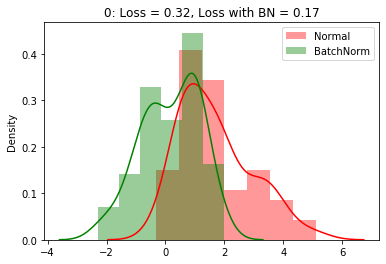

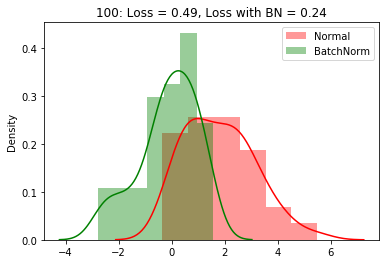

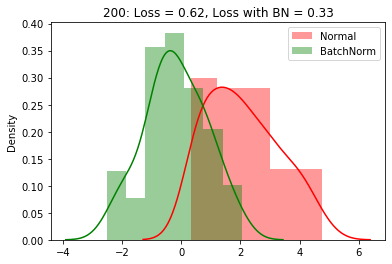

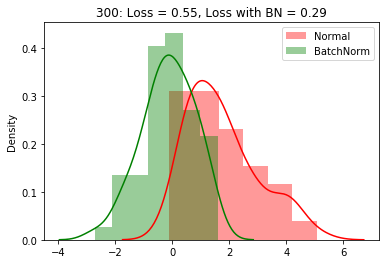

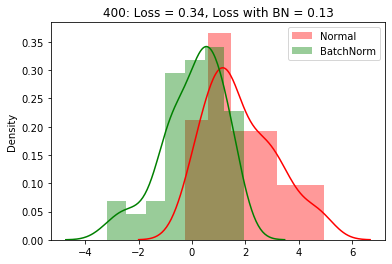

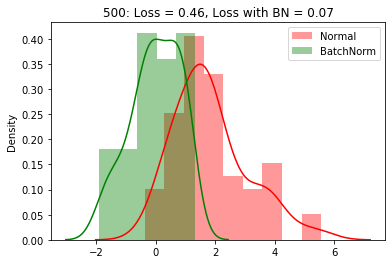

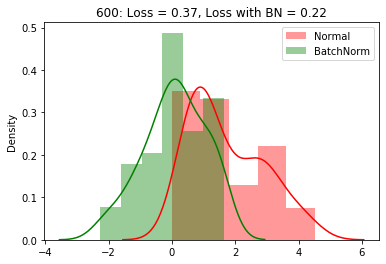

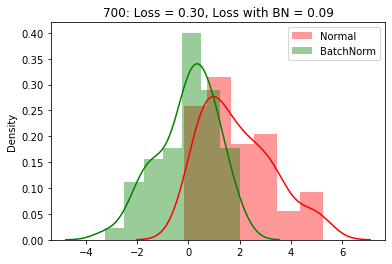

----------------------
3


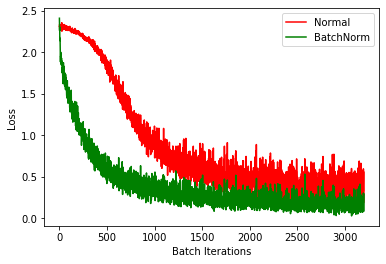

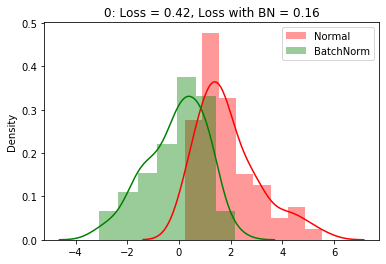

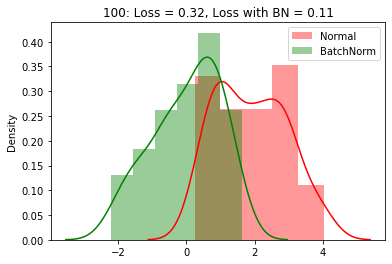

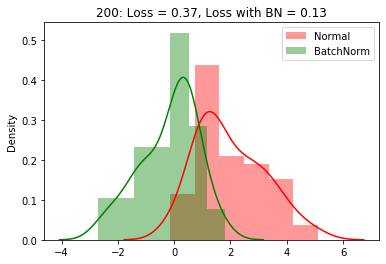

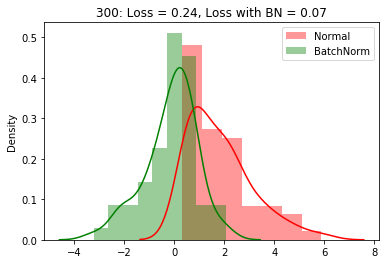

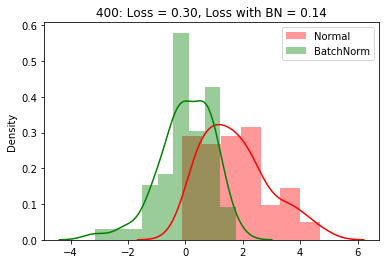

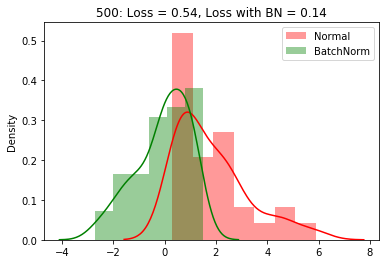

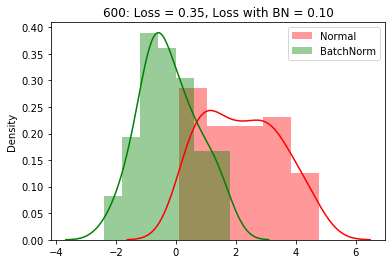

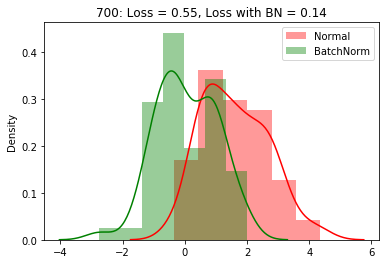

----------------------
4


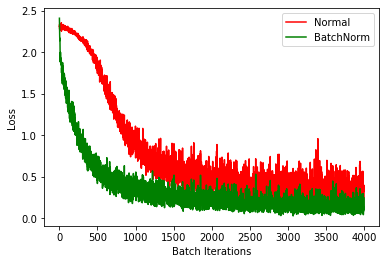

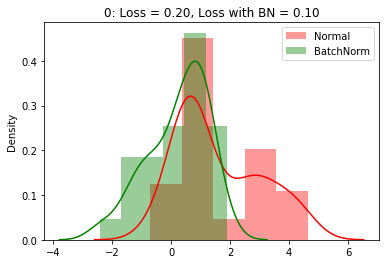

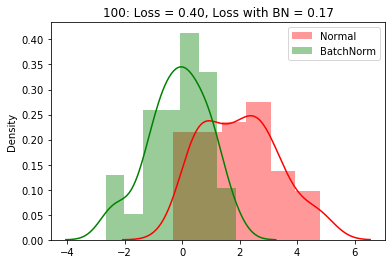

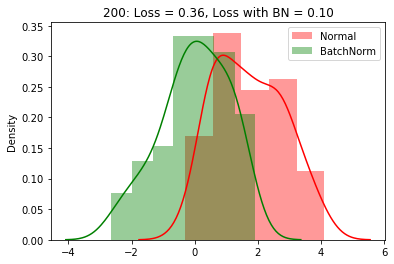

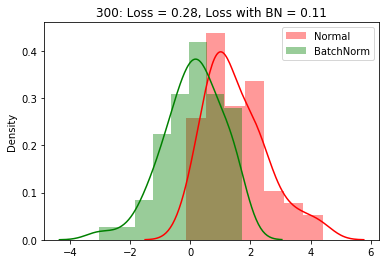

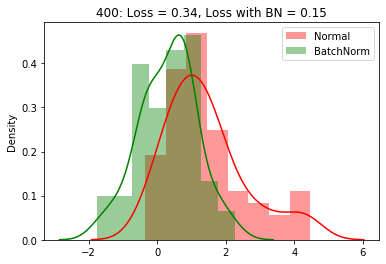

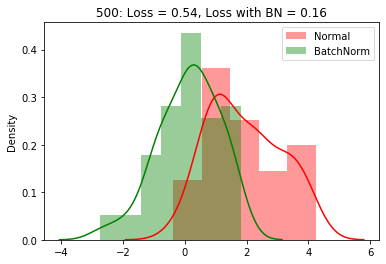

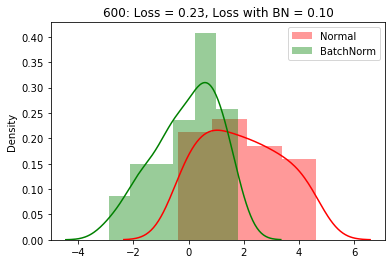

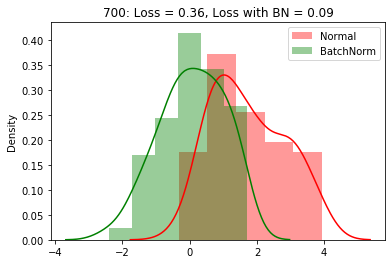

----------------------
5


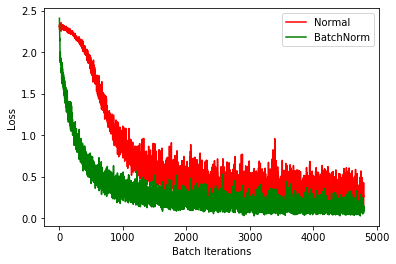

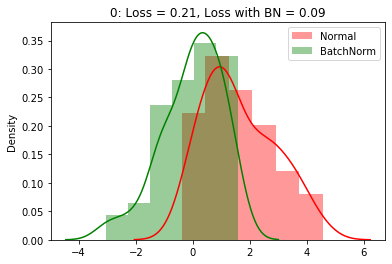

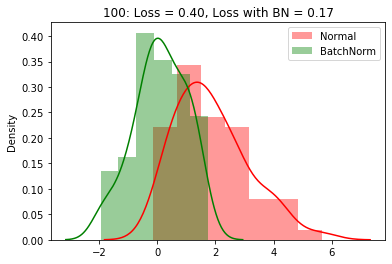

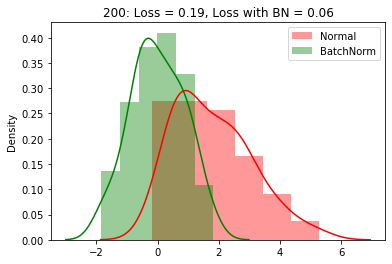

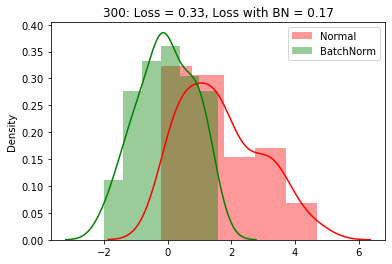

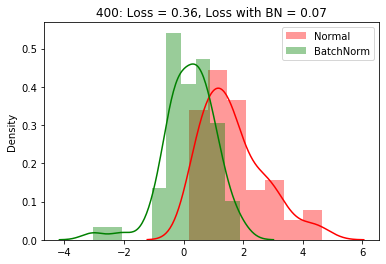

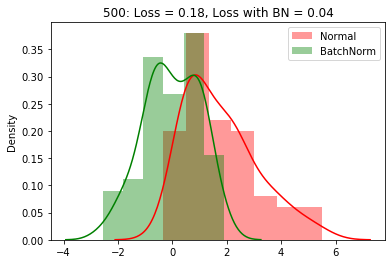

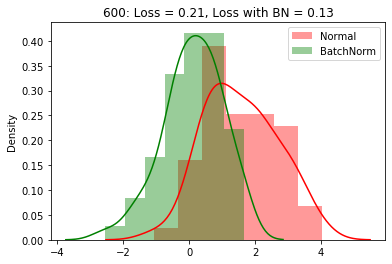

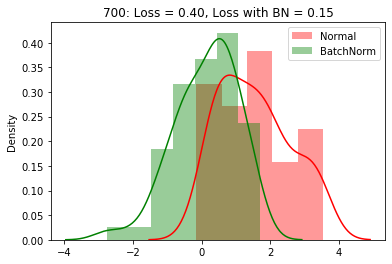

----------------------
6


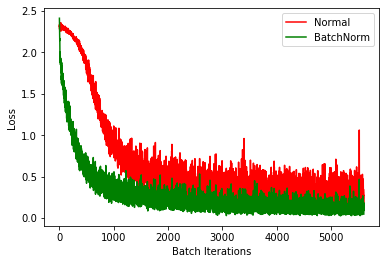

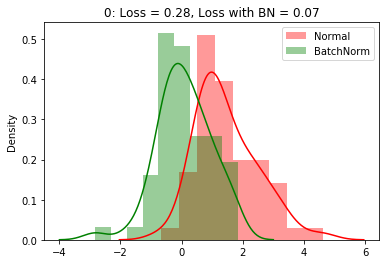

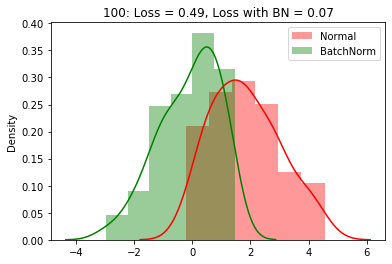

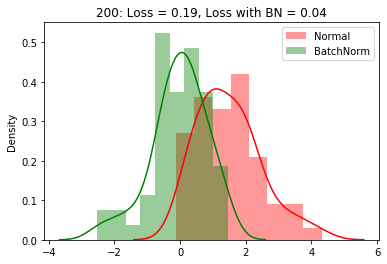

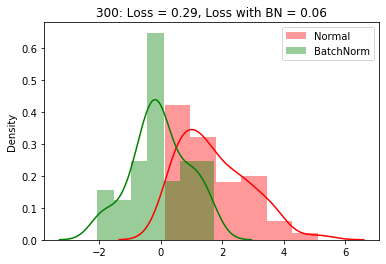

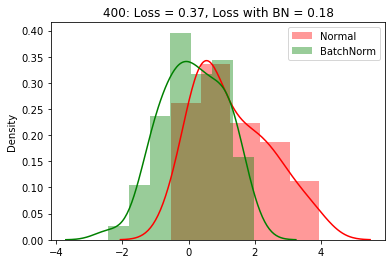

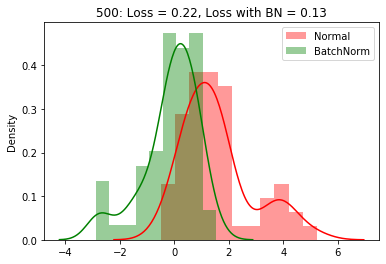

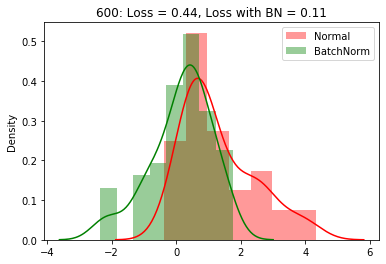

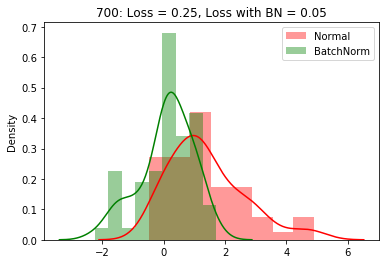

----------------------
7


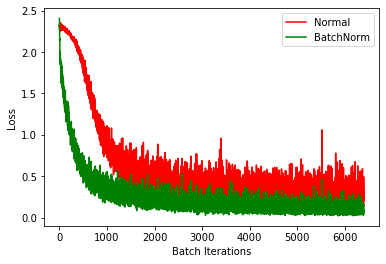

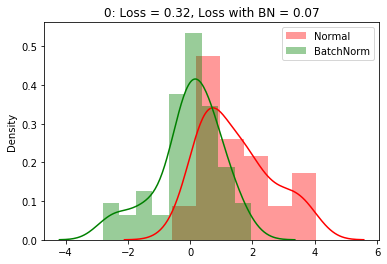

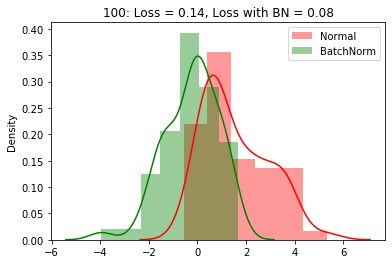

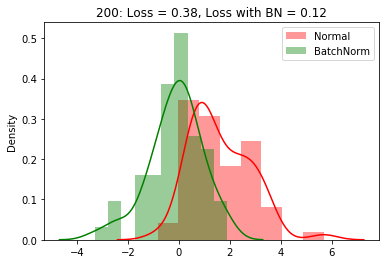

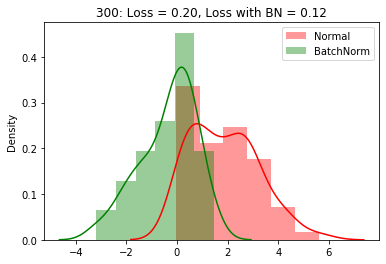

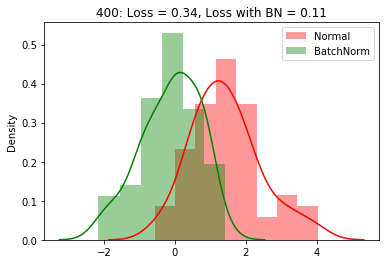

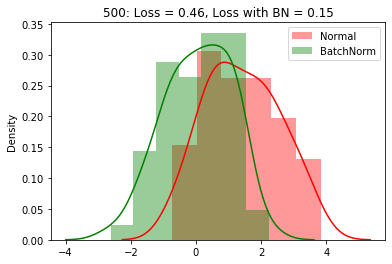

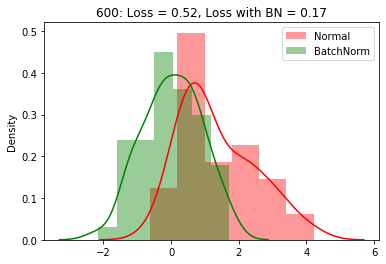

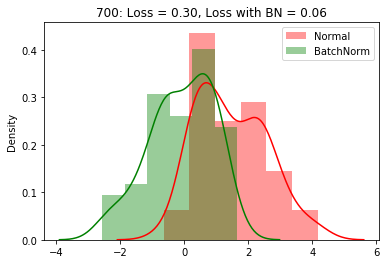

----------------------
8


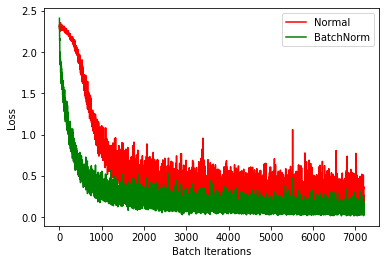

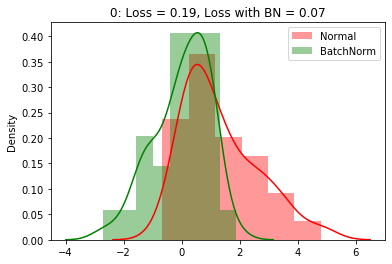

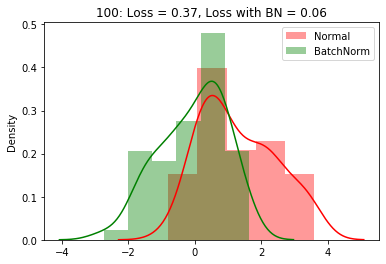

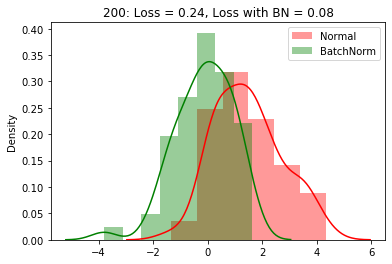

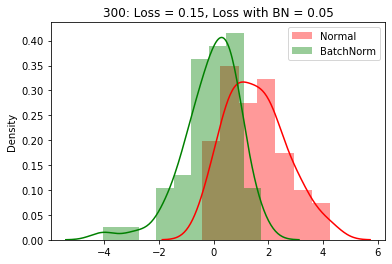

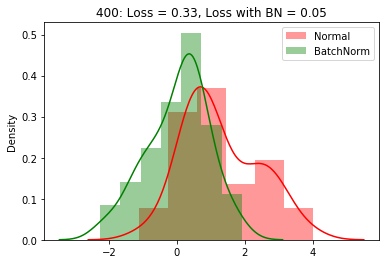

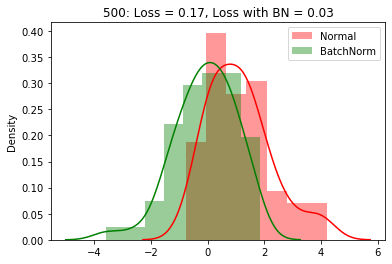

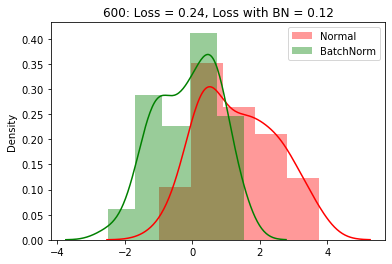

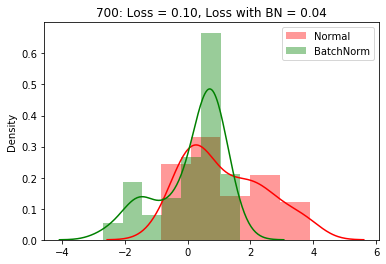

----------------------
9


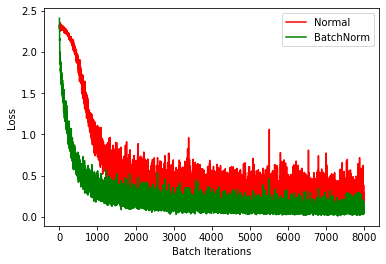

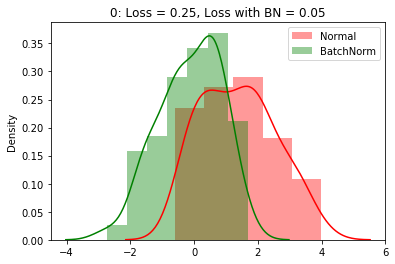

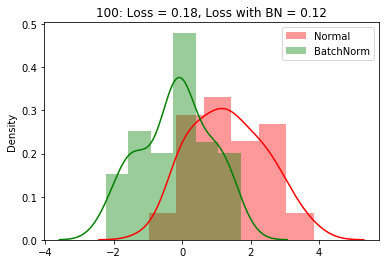

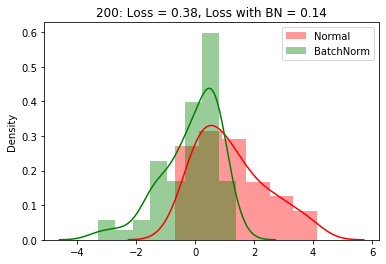

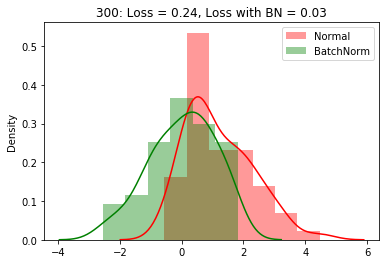

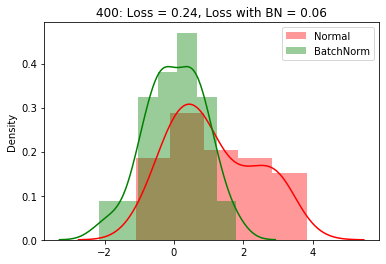

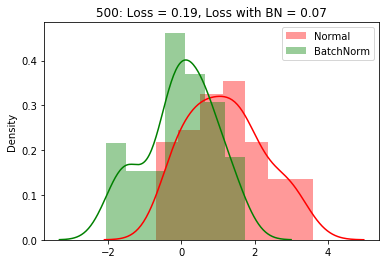

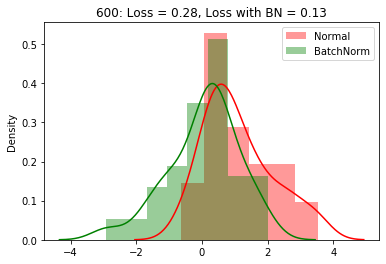

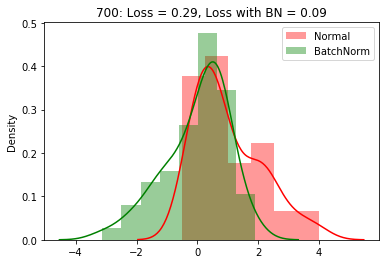

----------------------
10


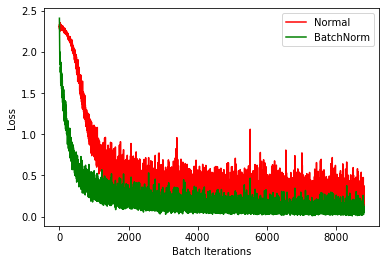

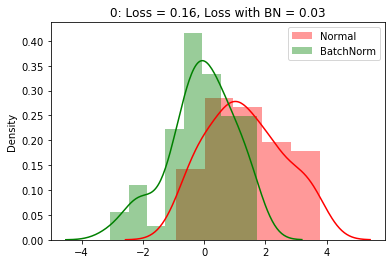

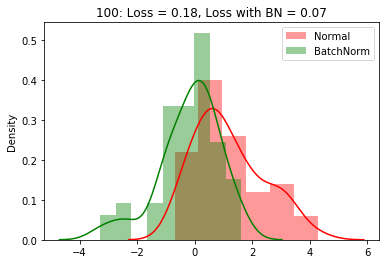

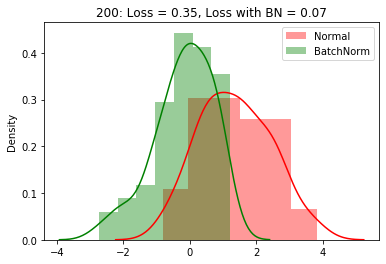

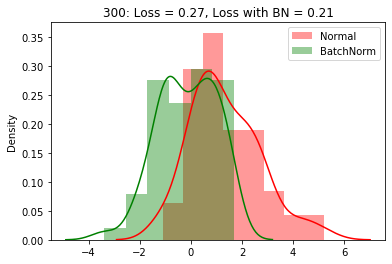

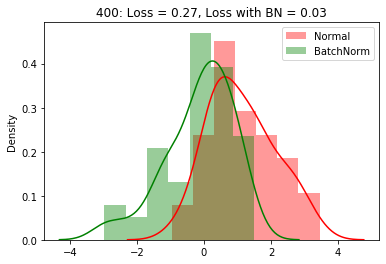

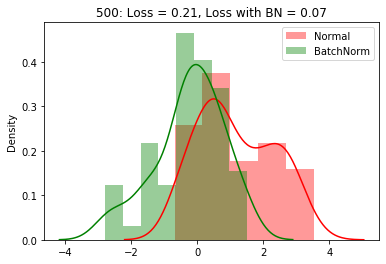

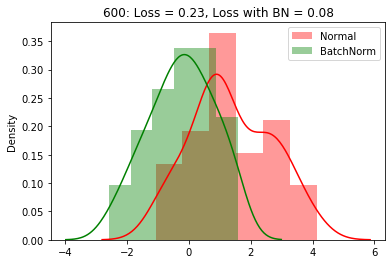

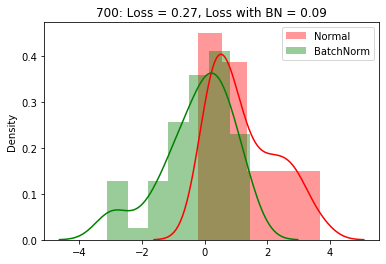

----------------------
11


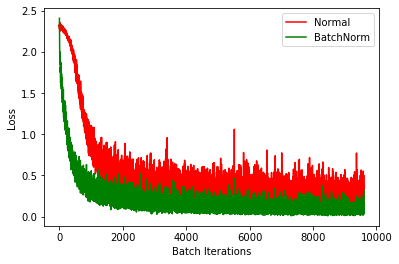

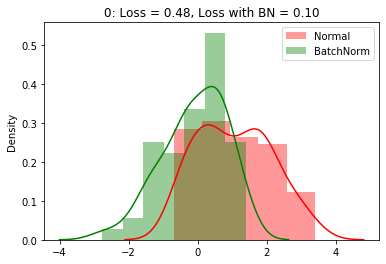

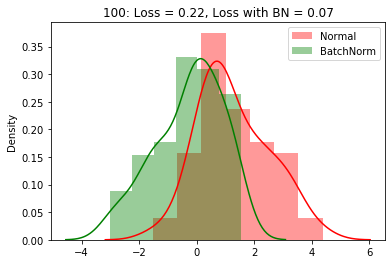

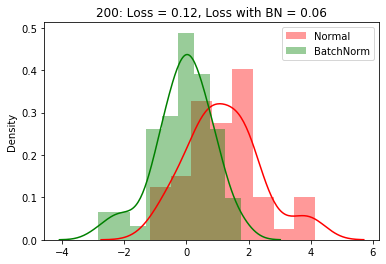

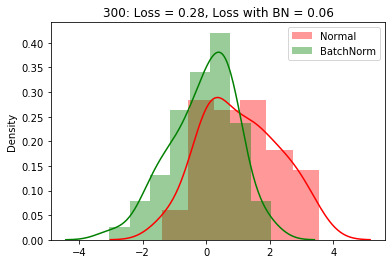

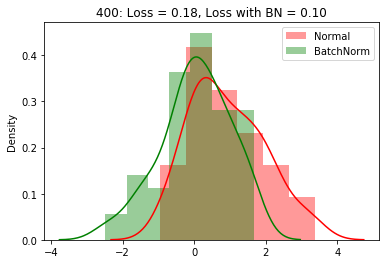

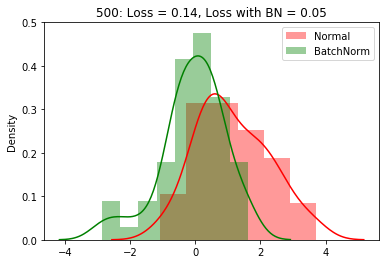

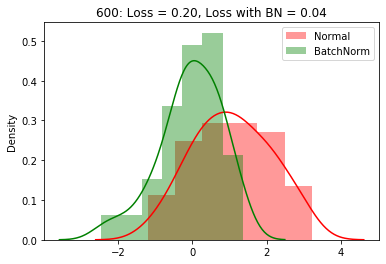

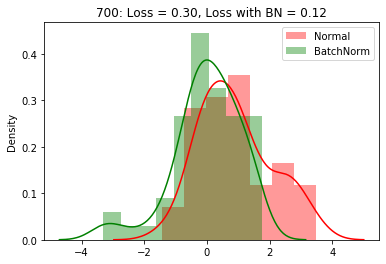

----------------------
12


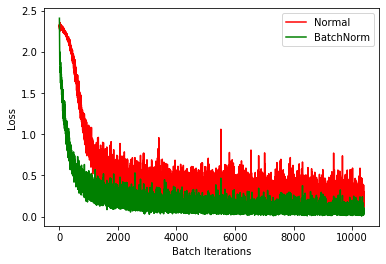

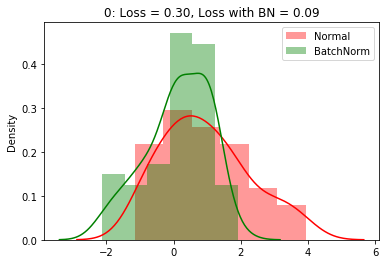

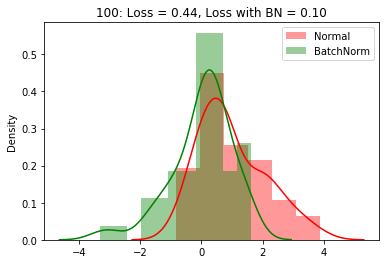

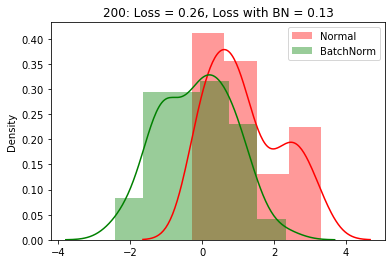

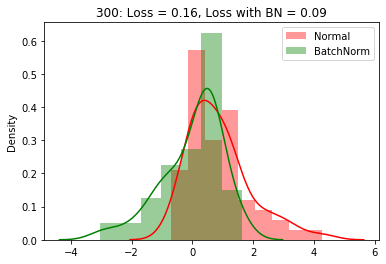

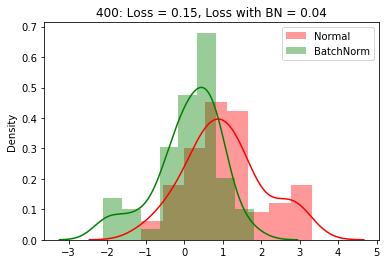

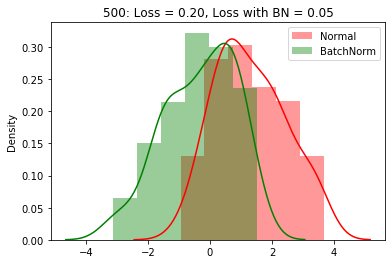

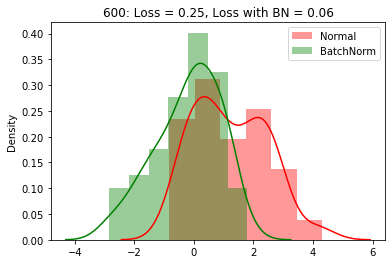

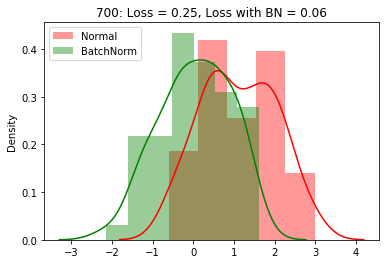

----------------------
13


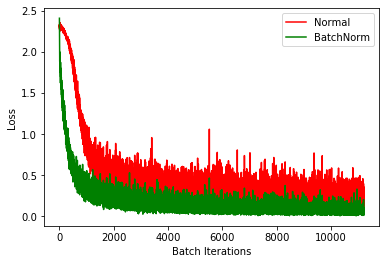

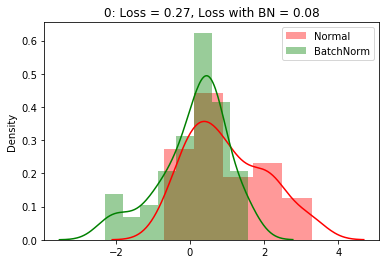

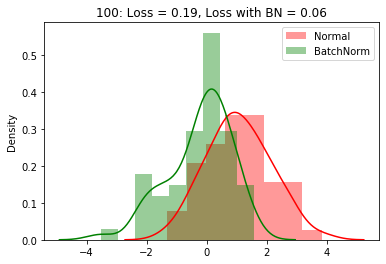

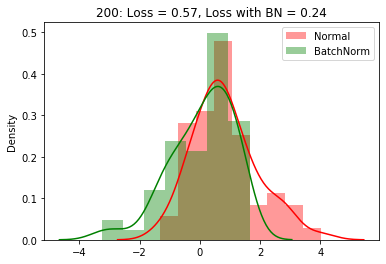

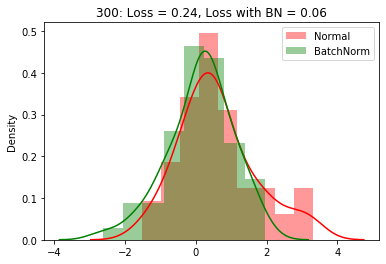

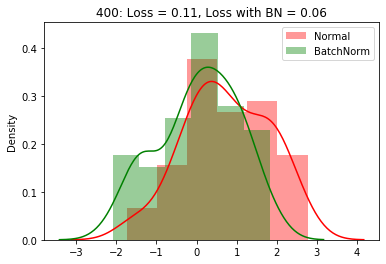

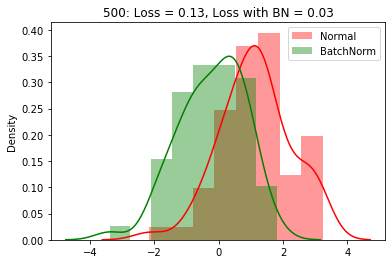

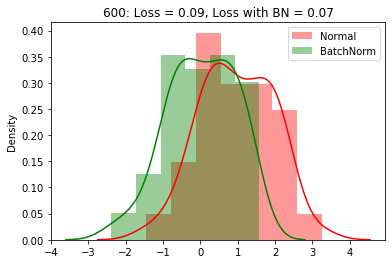

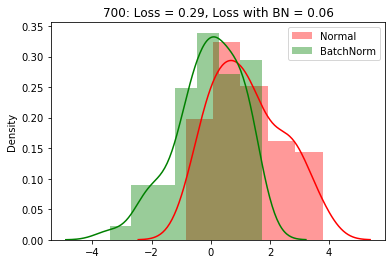

----------------------
14


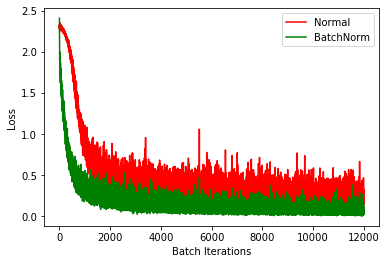

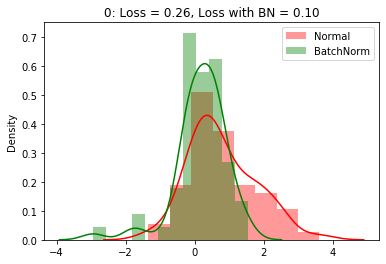

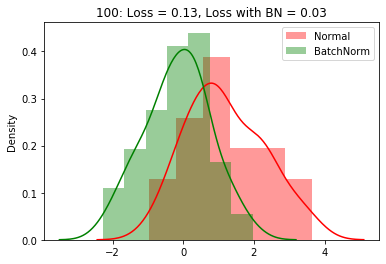

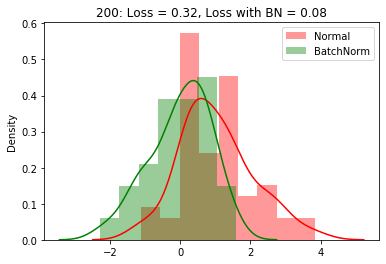

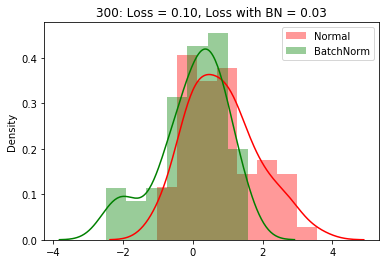

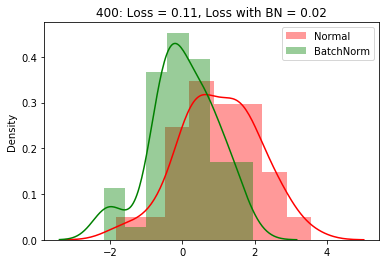

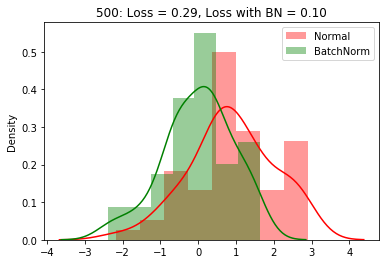

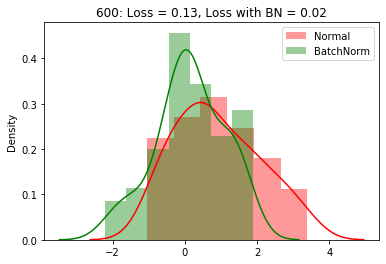

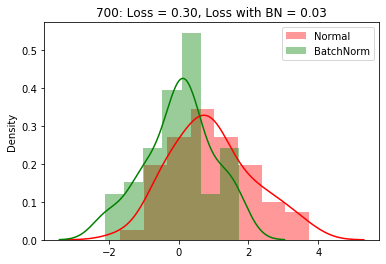

----------------------
15


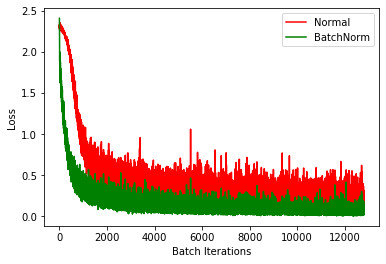

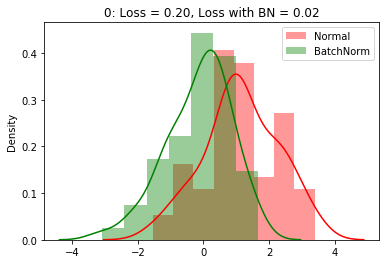

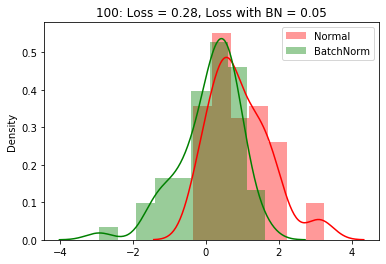

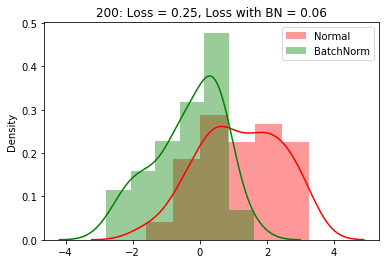

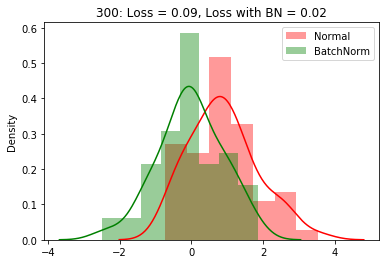

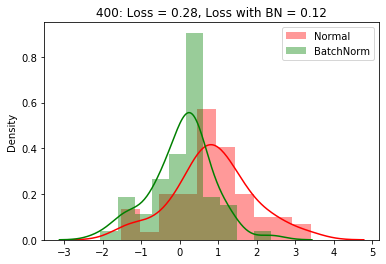

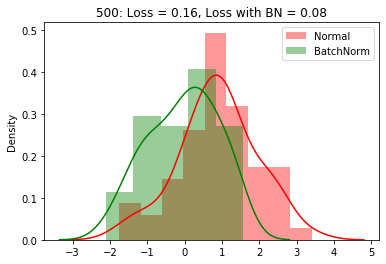

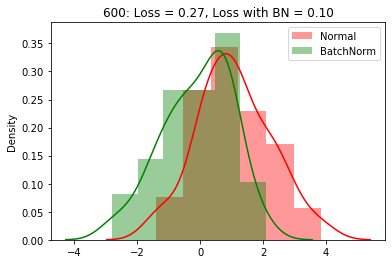

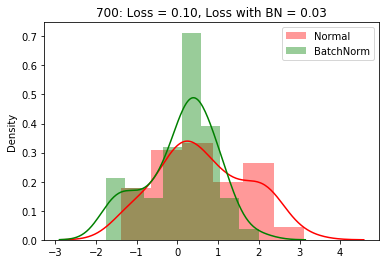

----------------------
16


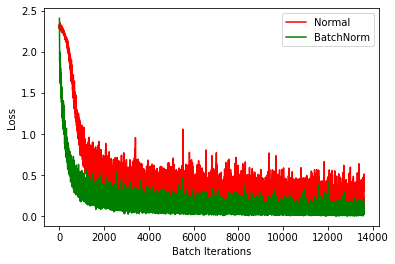

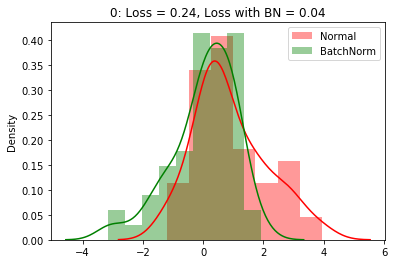

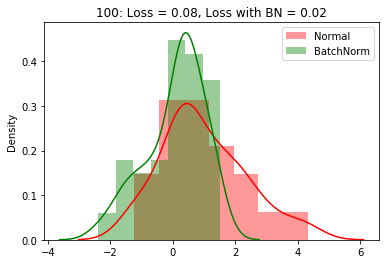

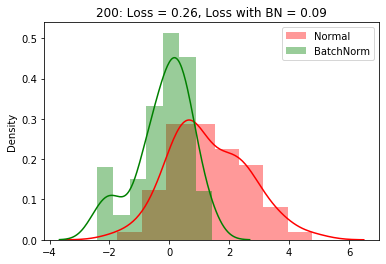

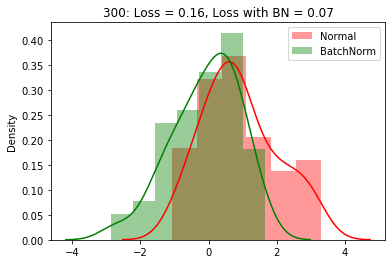

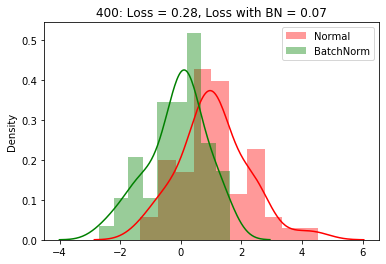

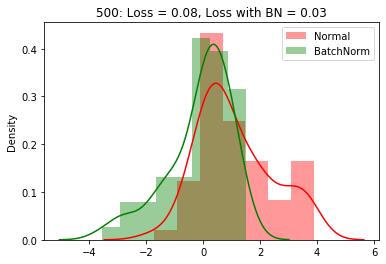

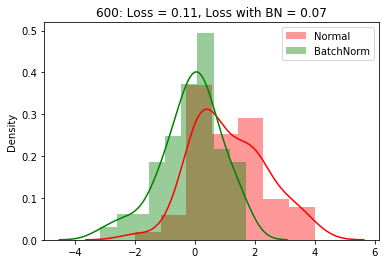

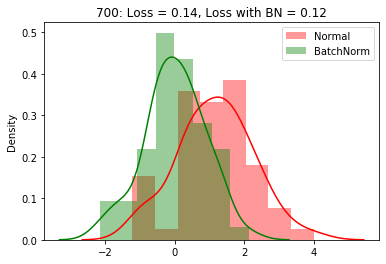

----------------------
17


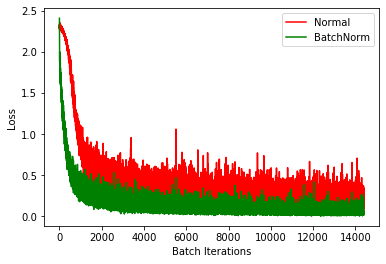

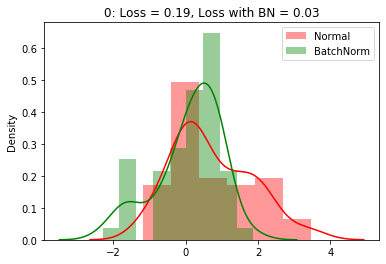

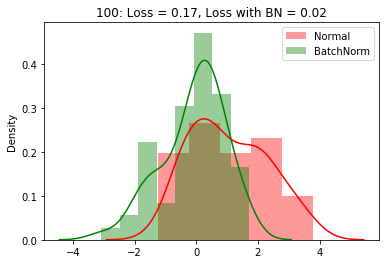

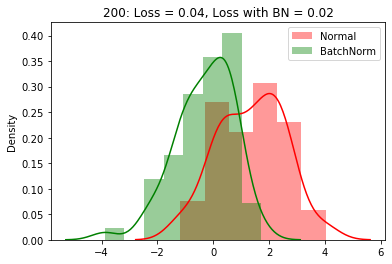

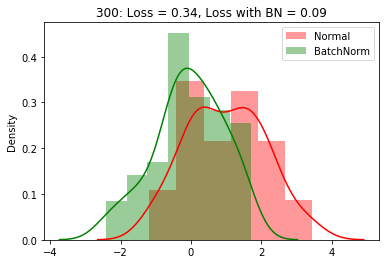

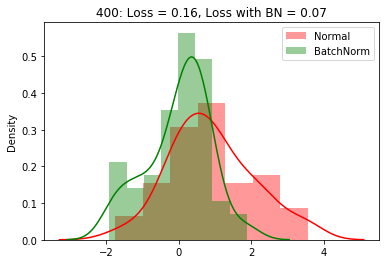

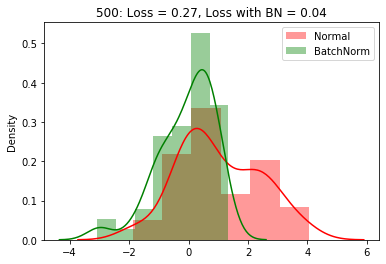

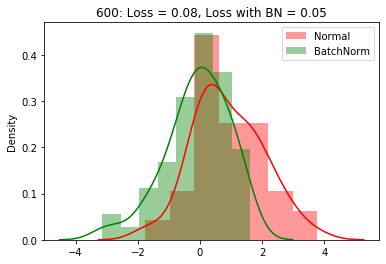

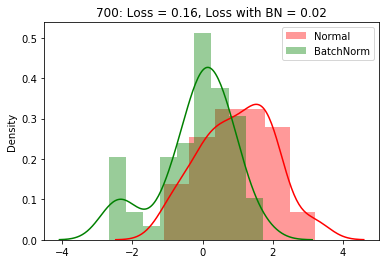

----------------------
18


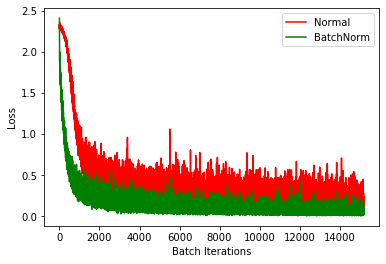

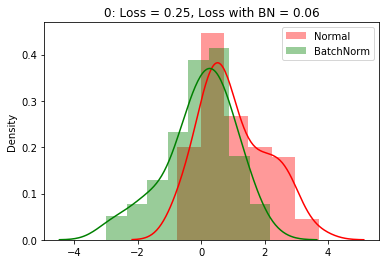

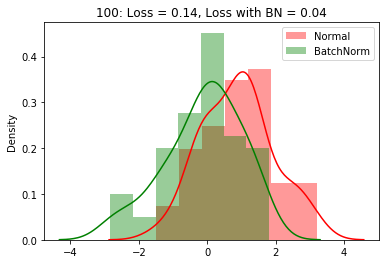

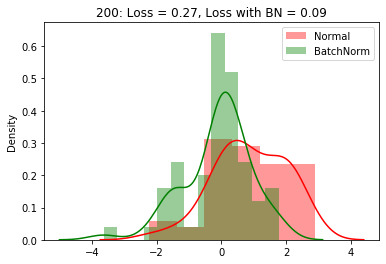

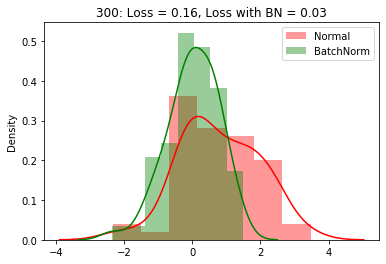

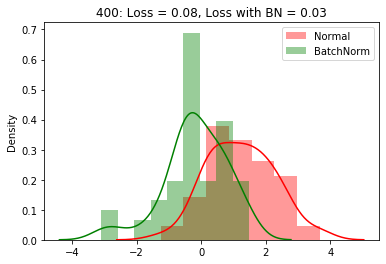

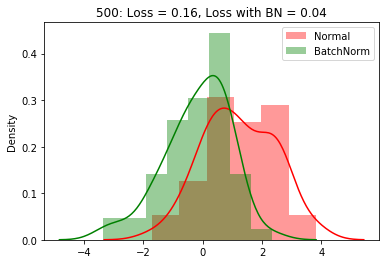

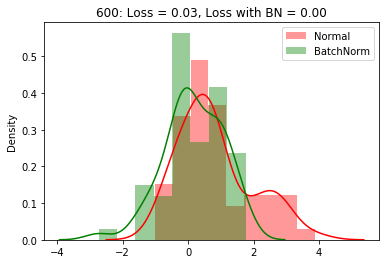

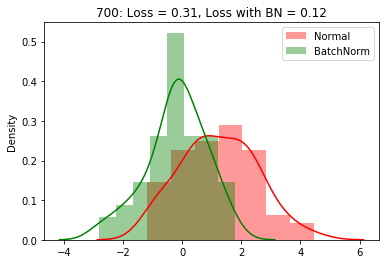

----------------------
19


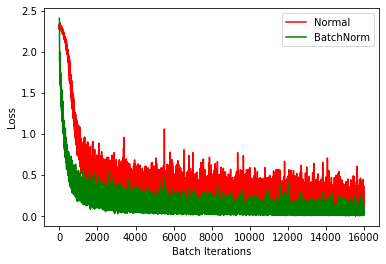

In [12]:
import warnings

with warnings.catch_warnings(record=True):
    
    loss_arr = []
    loss_bn_arr = []
    epochs_stats = []

    # TODO: set number of epochs
    max_epochs = 20

    for epoch in range(max_epochs):

        for i, data in enumerate(trainloader, 0):

            inputs, labels = data



            # training steps for normal model
            # print("train")
            # activations get added here so track iteration
            epochs_stats.append(i+epoch*len(trainloader))
            opt.zero_grad()
            outputs = model(inputs.to(device))
            loss = loss_fn(outputs, labels.to(device))
            loss.backward()
            opt.step()

            # training steps for bn model
            opt_bn.zero_grad()
            outputs_bn = model_bn(inputs.to(device))
            loss_bn = loss_fn(outputs_bn, labels.to(device))
            loss_bn.backward()
            opt_bn.step()

            loss_arr.append(loss.item())
            loss_bn_arr.append(loss_bn.item())


            if i % 100 == 0:
                inputs = inputs.view(inputs.size(0), -1)
                model.eval()
                model_bn.eval()

                # plot input layer distributions
                # first linear layer
                a = model.classifier[0](inputs.to(device))
                # inputs to first layer, first node
                a = a[:,0].cpu().detach().numpy().ravel()
                sns.distplot(a, kde=True, color='r', label='Normal') 

                # first linear layer, batch layer
                b = model_bn.classifier[0](inputs.to(device))
                b = model_bn.classifier[1](b)
                # inputs to first layer, first node
                b = b[:,0].cpu().detach().numpy().ravel()

                sns.distplot(b, kde=True, color='g', label='BatchNorm') 
                plt.title('%d: Loss = %0.2f, Loss with BN = %0.2f' % (i, loss.item(), loss_bn.item()))
                plt.legend()
                plt.show()
                plt.pause(0.5)
                model.train()
                model_bn.train()

        print('----------------------')
        print(epoch)
        plt.plot(loss_arr, 'r', label='Normal')
        plt.plot(loss_bn_arr, 'g', label='BatchNorm')
        plt.xlabel("Batch Iterations")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()

    # loss of the network with batch normalization reduces much faster than the normal network

There were quite a few visualizations produced while training the models.
We have density plots which show the distribution of the inputs to the first activation for the first node for each model and the loss of the models throughout batch iterations. 

**TODO: what are we seeing from the density plots? Think about the pixel value distributions of some of the MNIST data at the beginning, would this influence the output of our plots?**

The probability densities grow more similar over time, but both consistently have a mean of 0.  Initially the BatchNorm plots have a lower maximum, but thicker tail, compared to the Normal plots which have a significant spike at 0.  This spike at 0 corresponds well to the pixel value distributions at the beginning where the vast majority of the pixels have a value of 0.  Occasionally there is a slight second peak near 1 signifying that there is a not insignificant number of pixel values near 1.

**TODO: compare the loss over time from the vanilla model with the batch norm model. What can we infer from this?**

The losses grow more similar, however the loss from the Vanilla model is slightly larger than the loss from the BatchNorm model even after they converge.  It can be seen above that BatchNorm will converge faster than the Vanilla model.

In [13]:
# Get last hidden layer activation (ActivationTracker layer)
# TODO: which layer of the model to use?
baseline_activation = model.get_model()[3].get_all_activations()
bn_activation = model_bn.get_model()[5].get_all_activations()
print(len(baseline_activation))  # will match len(epochs_stats)
print(len(epochs_stats))

16000
16000


In the paper, they show how the activations from the last layer change during training and compare the Vanilla network to the BatchNorm network (Figure 1(b) and 1(c)).

**TODO: What effect would we expect BatchNorm to have on these last layer activations?**
The activations with BatchNorm will be in a smaller range, specifically mostly between -1 and 1 since the standard deviation is changed to 1.  As well, the 0.5 percentile is around 0, since the mean is changed to 0.  They also change little during the learning process.

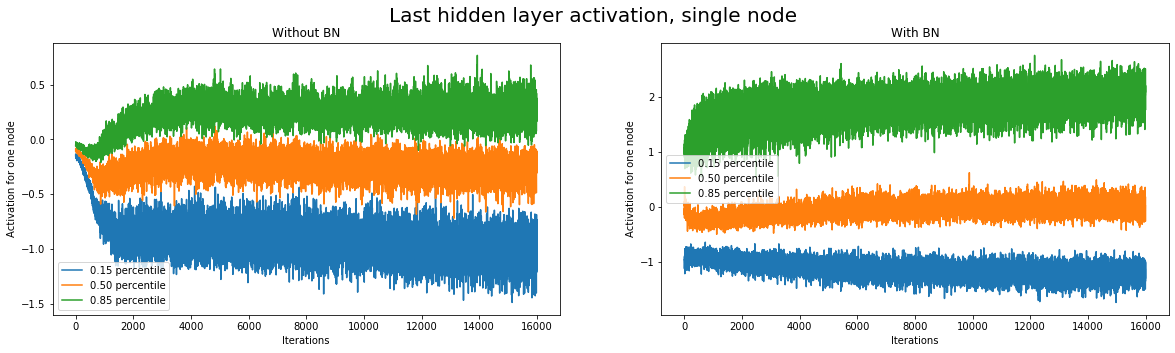

In [14]:
# Display activations
if epochs_stats: 
    fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))

    # -- All iterations
    # Baseline
    ax[0].plot(epochs_stats, baseline_activation[:, 0], label = f"0.15 percentile")
    ax[0].plot(epochs_stats, baseline_activation[:, 1], label = f"0.50 percentile")
    ax[0].plot(epochs_stats, baseline_activation[:, 2], label = f"0.85 percentile")
    ax[0].set_title('Without BN')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Activation for one node')
    
    # BN based
    ax[1].plot(epochs_stats, bn_activation[:, 0], label = f"0.15 percentile")
    ax[1].plot(epochs_stats, bn_activation[:, 1], label = f"0.50 percentile")
    ax[1].plot(epochs_stats, bn_activation[:, 2], label = f"0.85 percentile")
    ax[1].set_title('With BN')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Activation for one node')
    
    ax[0].legend(); ax[1].legend()
    plt.suptitle('Last hidden layer activation, single node', fontsize=20)
    plt.show()

**TODO: How do your plots compare to those in the paper? How do they compare to each other? What might explain the differences that you're seeing?**

The plots are similar to the ones in the paper, however all the plots in the notebook start from around 0.  In the paper the plot of the hidden activation for the network without batch normalization starts at about 1.  The plot of the network with batch normalization appears very similar in both the paper and the notebook, where the 15th percentile is around -1, 50th percentile around 0, and 85th percentile around 1.  This is likely because the weights in the paper were initialized with a gaussian centered around 1, whereas in the notebook the gaussian is centered around 0.  However, if this is bassed through a batch normalization layer first, then no matter the initial mean of the gaussian the data will be forced to identical distributions.  

The difference between the batch normalization and non-batch normalization nets is significant in both the paper and notebook.  First, note that there is a significant gap between the percentiles in the batch normalization net compared to the non-batch normalization net where the diference is small.  As well, in the batch normalization net, the activation converged to by the 85th percentile is different compared to the non-batch normalization net (2 compared to 0.5).  As discussed in the paper these plots show the layer converging towards a sigmoid.  Thus, with batch normalization the sigmoid converged to is much tighter than the one without batch normalization, fewer examples cluster around 0.  As well, note in the paper that graphs are over 50k iterations whereas the above plots are only over 16k iterations.  Given the behavior of the plots in the paper, the difference in training time can also be observed.  This is likely the cause of the difference in activations of the 85th percentile.  Using the non-batch normalization net a similar convergence would likely be reached if trained for a larger number of iterations.

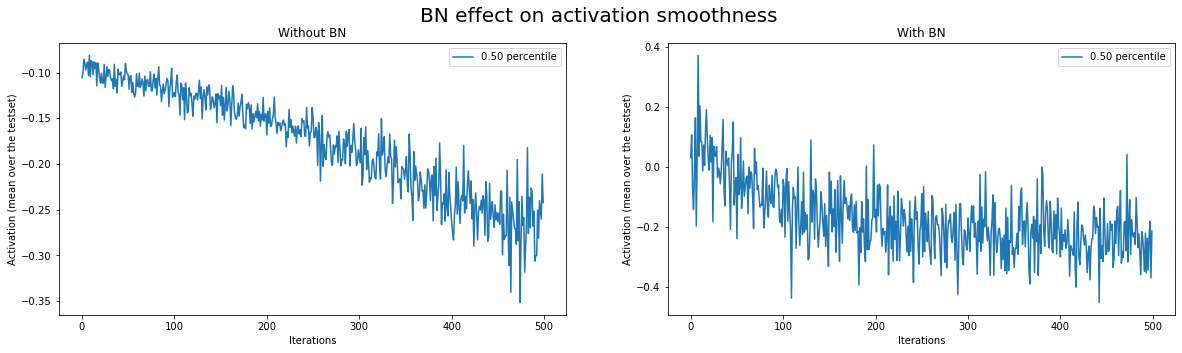

In [15]:
# --Zoom into beginning of above plots to visualize smoothing effect
small_window = 500

if epochs_stats: 
    fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))

    # Baseline
    ax[0].plot(epochs_stats[:small_window], baseline_activation[:small_window, 1], label = f"0.50 percentile")
    ax[0].set_title('Without BN')
    ax[0].set_xlabel('Iterations')
    ax[0].set_ylabel('Activation (mean over the testset)')
    
    # BN based
    ax[1].plot(epochs_stats[:small_window], bn_activation[:small_window, 1], label = f"0.50 percentile")
    ax[1].set_title('With BN')
    ax[1].set_xlabel('Iterations')
    ax[1].set_ylabel('Activation (mean over the testset)')
    
    ax[0].legend(); ax[1].legend()
    plt.suptitle('BN effect on activation smoothness', fontsize=20)
    plt.show()

In [16]:
# Evaluate accuracy of the models
# vanilla accuracy
acc1 = get_accuracy(model, trainloader)
print(f"Epoch {epoch} Vanilla Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model, testloader)
print(f"Epoch {epoch} Vanilla Test Accuracy: {acc2 * 100:.02f}%\n")

# batch normalization accuracy
acc1 = get_accuracy(model_bn, trainloader)
print(f"Epoch {epoch} BN Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_bn, testloader)
print(f"Epoch {epoch} BN Test Accuracy: {acc2 * 100:.02f}%\n")

Epoch 19 Vanilla Train Accuracy: 95.29%
Epoch 19 Vanilla Test Accuracy: 94.62%

Epoch 19 BN Train Accuracy: 98.76%
Epoch 19 BN Test Accuracy: 96.51%



**TODO: How does the accuracy of the models with and without BatchNorm compare?**

Both models acheive a high test accuracy, 94.62% with the Vanilla Net and 96.51% with the batch norm net, however the batch norm net acheives a slightly better accuracy using an equivalent number of training epochs.

### Changed Architecture, Learning Rate, and Iterations
#### Use Paper Architecture

In [29]:
# Create a basic network
class VanillaNN_Paper(nn.Module):
    def __init__(self): 
        super(VanillaNN_Paper, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28*28,100),
            nn.Sigmoid(),
            nn.Linear(100,100),
            nn.Sigmoid(),
            nn.Linear(100,100),
            ActivationTracker(),
            nn.Sigmoid(),
            nn.Linear(100,10)
        )
        self.classifier.apply(init_weights)
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def get_model(self):
        return self.classifier
    
# Using the same structure of the basic network as above, add batch normalization to the input layers
class BatchNormNN_Paper(nn.Module):
    def __init__(self): 
        super(BatchNormNN_Paper, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(28*28,100),
            
            nn.Sigmoid(),
            nn.Linear(100,100),
             
            nn.Sigmoid(),
            nn.Linear(100,100),
            
            ActivationTracker(),
            nn.Sigmoid(),
            nn.Linear(100,10)
        )
        self.classifier.apply(init_weights)
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def get_model(self):
        return self.classifier

#### Create Training Function, for Sake of Readability

In [33]:
def train(model,model_bn,eta=0.01,max_epochs=20):
    with warnings.catch_warnings(record=True):
        
        opt = optim.SGD(model.parameters(), lr=eta)
        opt_bn = optim.SGD(model_bn.parameters(), lr=eta)

        loss_arr = []
        loss_bn_arr = []
        epochs_stats = []

        for epoch in range(max_epochs):
            print(f'Epoch {epoch+1}/{max_epochs}')

            for i, data in enumerate(trainloader, 0):

                inputs, labels = data

                # training steps for normal model
                # print("train")
                # activations get added here so track iteration
                epochs_stats.append(i+epoch*len(trainloader))
                opt.zero_grad()
                outputs = model(inputs.to(device))
                loss = loss_fn(outputs, labels.to(device))
                loss.backward()
                opt.step()

                # training steps for bn model
                opt_bn.zero_grad()
                outputs_bn = model_bn(inputs.to(device))
                loss_bn = loss_fn(outputs_bn, labels.to(device))
                loss_bn.backward()
                opt_bn.step()

                loss_arr.append(loss.item())
                loss_bn_arr.append(loss_bn.item())

                if i % 100 == 0:
                    inputs = inputs.view(inputs.size(0), -1)
                    model.eval()
                    model_bn.eval()
                    
                    '''

                    # plot input layer distributions
                    # first linear layer
                    a = model.classifier[0](inputs.to(device))
                    # inputs to first layer, first node
                    a = a[:,0].cpu().detach().numpy().ravel()
                    sns.distplot(a, kde=True, color='r', label='Normal') 

                    # first linear layer, batch layer
                    b = model_bn.classifier[0](inputs.to(device))
                    b = model_bn.classifier[1](b)
                    # inputs to first layer, first node
                    b = b[:,0].cpu().detach().numpy().ravel()

                    sns.distplot(b, kde=True, color='g', label='BatchNorm') 
                    plt.title('%d: Loss = %0.2f, Loss with BN = %0.2f' % (i, loss.item(), loss_bn.item()))
                    plt.legend()
                    plt.show()
                    plt.pause(0.5)
                    '''
                    model.train()
                    model_bn.train()
                    
            '''        
            print('----------------------')
            print(epoch)
            plt.plot(loss_arr, 'r', label='Normal')
            plt.plot(loss_bn_arr, 'g', label='BatchNorm')
            plt.xlabel("Batch Iterations")
            plt.ylabel("Loss")
            plt.legend()
            plt.show()
            '''

    return epochs_stats

#### Create Plotting Functions For Sake of Readability

In [35]:
def full_activations(epochs_stats,baseline_activation,bn_activation):
    # Display activations
    if epochs_stats: 
        fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))

        # -- All iterations
        # Baseline
        ax[0].plot(epochs_stats, baseline_activation[:, 0], label = f"0.15 percentile")
        ax[0].plot(epochs_stats, baseline_activation[:, 1], label = f"0.50 percentile")
        ax[0].plot(epochs_stats, baseline_activation[:, 2], label = f"0.85 percentile")
        ax[0].set_title('Without BN')
        ax[0].set_xlabel('Iterations')
        ax[0].set_ylabel('Activation for one node')

        # BN based
        ax[1].plot(epochs_stats, bn_activation[:, 0], label = f"0.15 percentile")
        ax[1].plot(epochs_stats, bn_activation[:, 1], label = f"0.50 percentile")
        ax[1].plot(epochs_stats, bn_activation[:, 2], label = f"0.85 percentile")
        ax[1].set_title('With BN')
        ax[1].set_xlabel('Iterations')
        ax[1].set_ylabel('Activation for one node')

        ax[0].legend(); ax[1].legend()
        plt.suptitle('Last hidden layer activation, single node', fontsize=20)
        plt.show()

def average_activations(epochs_stats,baseline_activation,bn_activation):
    # --Zoom into beginning of above plots to visualize smoothing effect
    small_window = 500

    if epochs_stats: 
        fig, ax = plt.subplots(1, 2, figsize=(10*2, 5))

        # Baseline
        ax[0].plot(epochs_stats[:small_window], baseline_activation[:small_window, 1], label = f"0.50 percentile")
        ax[0].set_title('Without BN')
        ax[0].set_xlabel('Iterations')
        ax[0].set_ylabel('Activation (mean over the testset)')

        # BN based
        ax[1].plot(epochs_stats[:small_window], bn_activation[:small_window, 1], label = f"0.50 percentile")
        ax[1].set_title('With BN')
        ax[1].set_xlabel('Iterations')
        ax[1].set_ylabel('Activation (mean over the testset)')

        ax[0].legend(); ax[1].legend()
        plt.suptitle('BN effect on activation smoothness', fontsize=20)
        plt.show()

#### Training

In [34]:
#Notebook Architecture
model_e40 = VanillaNN().to(device)
model_bn_e40 = BatchNormNN().to(device)
epochs_stats_e40 = train(model_e40,model_bn_e40,max_epochs=40)

model_lr3 = VanillaNN().to(device)
model_bn_lr3 = BatchNormNN().to(device)
epochs_stats_lr3 = train(model_lr3,model_bn_lr3,eta=1e-3)

model_e40_lr3 = VanillaNN().to(device)
model_bn_e40_lr3 = BatchNormNN().to(device)
epochs_stats_e40_lr3 = train(model_e40_lr3,model_bn_e40_lr3,eta=1e-3,max_epochs=40)

#Paper Architecture
model_pap = VanillaNN_Paper().to(device)
model_bn_pap = BatchNormNN_Paper().to(device)
epochs_stats_pap = train(model_pap,model_bn_pap)

model_pap_e40 = VanillaNN_Paper().to(device)
model_bn_pap_e40 = BatchNormNN_Paper().to(device)
epochs_stats_pap_e40 = train(model_pap_e40,model_bn_pap_e40,max_epochs=40)

model_pap_lr3 = VanillaNN_Paper().to(device)
model_bn_pap_lr3 = BatchNormNN_Paper().to(device)
epochs_stats_pap_lr3 = train(model_pap_lr3,model_bn_pap_lr3,eta=1e-3)

model_pap_e40_lr3 = VanillaNN_Paper().to(device)
model_bn_pap_e40_lr3 = BatchNormNN_Paper().to(device)
epochs_stats_pap_e40_lr3 = train(model_pap_e40_lr3,model_bn_pap_e40_lr3,eta=1e-3,max_epochs=40)

Epoch 1/40
Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoch 8/40
Epoch 9/40
Epoch 10/40
Epoch 11/40
Epoch 12/40
Epoch 13/40
Epoch 14/40
Epoch 15/40
Epoch 16/40
Epoch 17/40
Epoch 18/40
Epoch 19/40
Epoch 20/40
Epoch 21/40
Epoch 22/40
Epoch 23/40
Epoch 24/40
Epoch 25/40
Epoch 26/40
Epoch 27/40
Epoch 28/40
Epoch 29/40
Epoch 30/40
Epoch 31/40
Epoch 32/40
Epoch 33/40
Epoch 34/40
Epoch 35/40
Epoch 36/40
Epoch 37/40
Epoch 38/40
Epoch 39/40
Epoch 40/40
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20
Epoch 20/20
Epoch 1/40
Epoch 2/40
Epoch 3/40
Epoch 4/40
Epoch 5/40
Epoch 6/40
Epoch 7/40
Epoch 8/40
Epoch 9/40
Epoch 10/40
Epoch 11/40
Epoch 12/40
Epoch 13/40
Epoch 14/40
Epoch 15/40
Epoch 16/40
Epoch 17/40
Epoch 18/40
Epoch 19/40
Epoch 20/40
Epoch 21/40
Epoch 22/40
Epoch 23/40
Epoch 24/40
Epoch 25/40
Epoch 2

40 Epochs

In [36]:
baseline_activation_e40 = model_e40.get_model()[3].get_all_activations()
bn_activation_e40 = model_bn_e40.get_model()[5].get_all_activations()

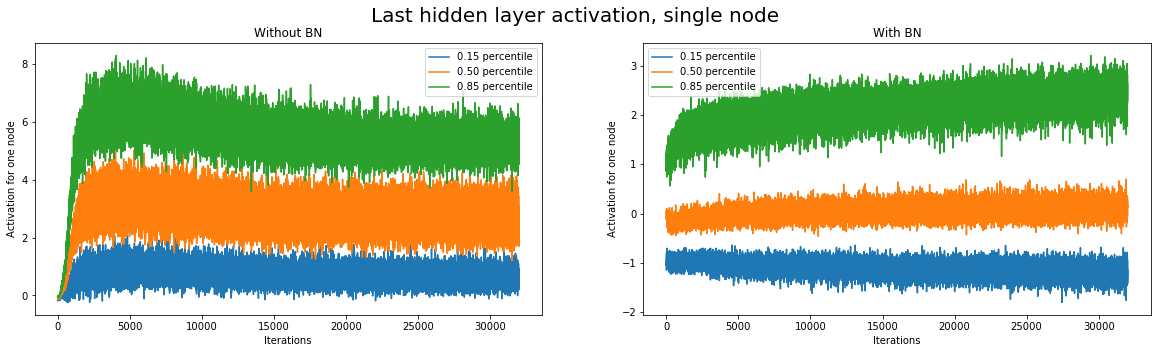

In [37]:
full_activations(epochs_stats_e40,baseline_activation_e40,bn_activation_e40)

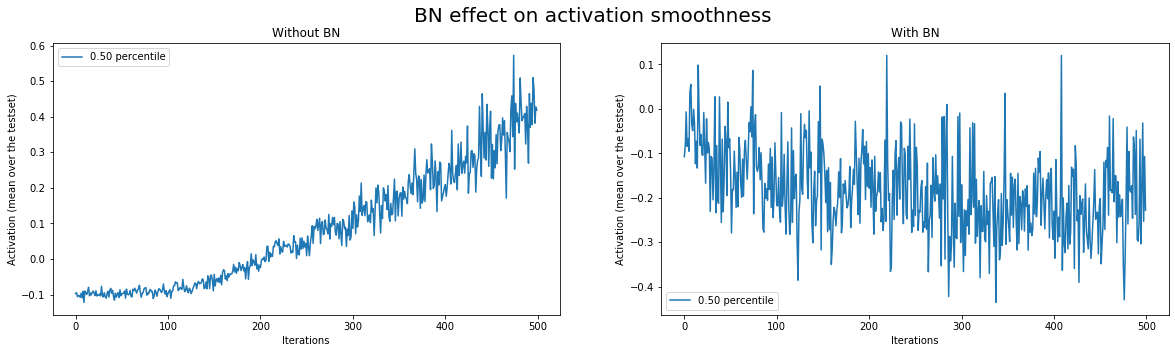

In [38]:
average_activations(epochs_stats_e40,baseline_activation_e40,bn_activation_e40)

In [62]:
# Evaluate accuracy of the models
# vanilla accuracy
acc1 = get_accuracy(model_e40, trainloader)
print(f"Epoch {39} Vanilla Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_e40, testloader)
print(f"Epoch {39} Vanilla Test Accuracy: {acc2 * 100:.02f}%\n")

# batch normalization accuracy
acc1 = get_accuracy(model_bn_e40, trainloader)
print(f"Epoch {39} BN Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_bn_e40, testloader)
print(f"Epoch {39} BN Test Accuracy: {acc2 * 100:.02f}%\n")

Epoch 39 Vanilla Train Accuracy: 97.40%
Epoch 39 Vanilla Test Accuracy: 96.18%

Epoch 39 BN Train Accuracy: 99.32%
Epoch 39 BN Test Accuracy: 96.73%



Learning Rate 1e-3

In [39]:
baseline_activation_lr3 = model_lr3.get_model()[3].get_all_activations()
bn_activation_lr3 = model_bn_lr3.get_model()[5].get_all_activations()

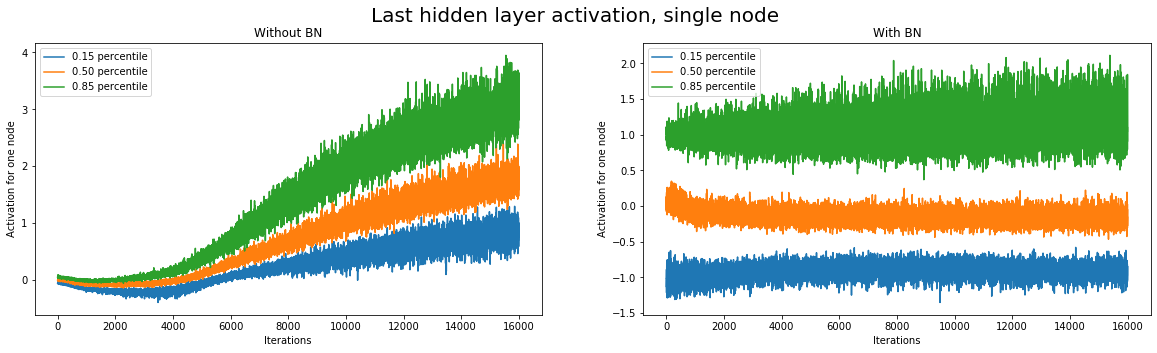

In [40]:
full_activations(epochs_stats_lr3,baseline_activation_lr3,bn_activation_lr3)

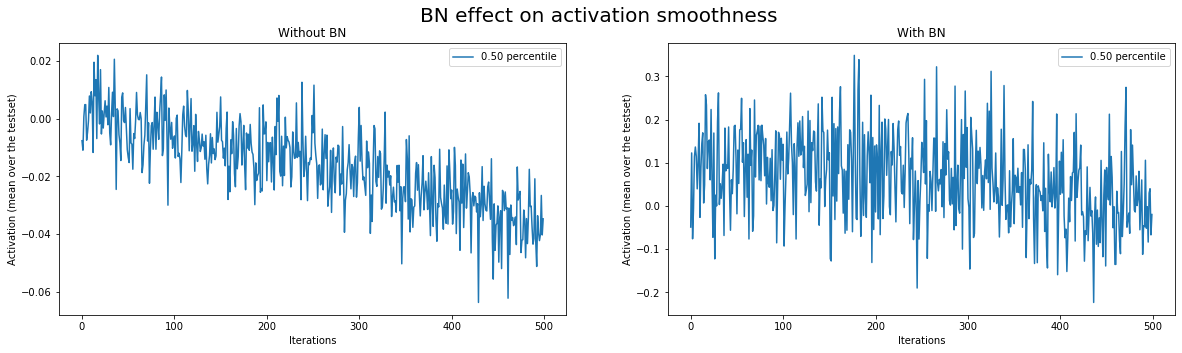

In [41]:
average_activations(epochs_stats_lr3,baseline_activation_lr3,bn_activation_lr3)

In [60]:
# Evaluate accuracy of the models
# vanilla accuracy
acc1 = get_accuracy(model_lr3, trainloader)
print(f"Epoch {19} Vanilla Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_lr3, testloader)
print(f"Epoch {19} Vanilla Test Accuracy: {acc2 * 100:.02f}%\n")

# batch normalization accuracy
acc1 = get_accuracy(model_bn_lr3, trainloader)
print(f"Epoch {19} BN Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_bn_lr3, testloader)
print(f"Epoch {19} BN Test Accuracy: {acc2 * 100:.02f}%\n")

Epoch 19 Vanilla Train Accuracy: 84.99%
Epoch 19 Vanilla Test Accuracy: 84.91%

Epoch 19 BN Train Accuracy: 94.63%
Epoch 19 BN Test Accuracy: 93.96%



40 Epochs, Learning Rate 1e-3

In [42]:
baseline_activation_e40_lr3 = model_e40_lr3.get_model()[3].get_all_activations()
bn_activation_e40_lr3 = model_bn_e40_lr3.get_model()[5].get_all_activations()

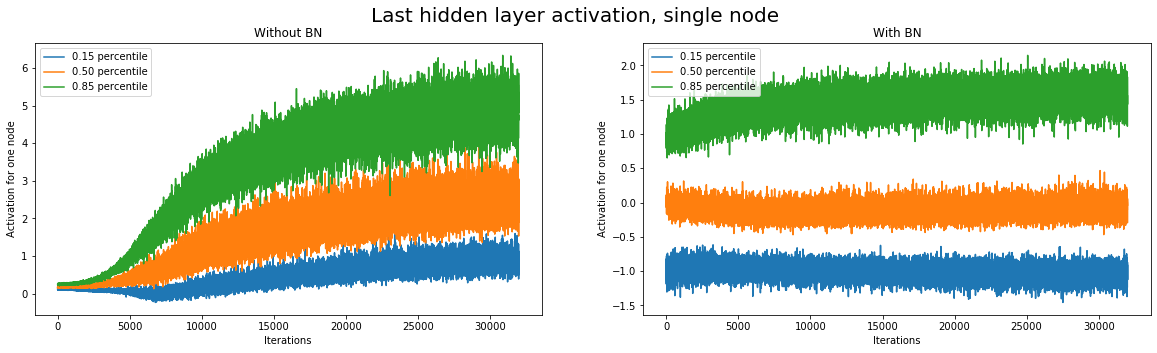

In [43]:
full_activations(epochs_stats_e40_lr3,baseline_activation_e40_lr3,bn_activation_e40_lr3)

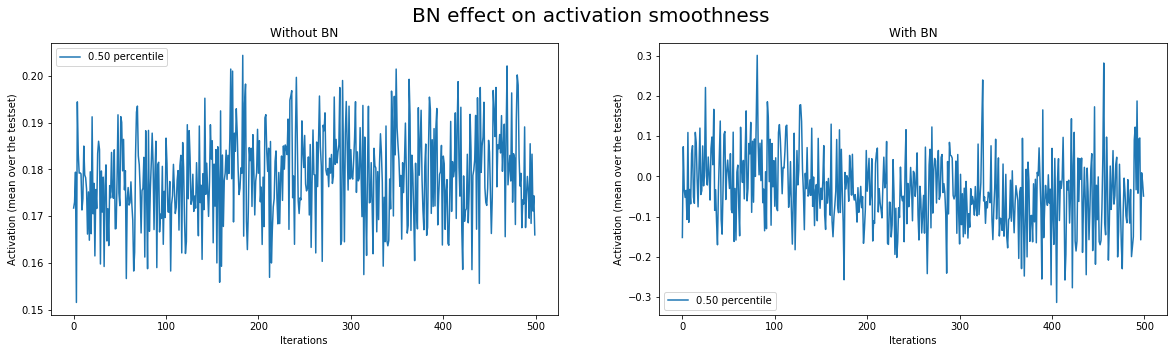

In [44]:
average_activations(epochs_stats_e40_lr3,baseline_activation_e40_lr3,bn_activation_e40_lr3)

In [61]:
# Evaluate accuracy of the models
# vanilla accuracy
acc1 = get_accuracy(model_e40_lr3, trainloader)
print(f"Epoch {39} Vanilla Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_e40_lr3, testloader)
print(f"Epoch {39} Vanilla Test Accuracy: {acc2 * 100:.02f}%\n")

# batch normalization accuracy
acc1 = get_accuracy(model_bn_e40_lr3, trainloader)
print(f"Epoch {39} BN Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_bn_e40_lr3, testloader)
print(f"Epoch {39} BN Test Accuracy: {acc2 * 100:.02f}%\n")

Epoch 39 Vanilla Train Accuracy: 89.52%
Epoch 39 Vanilla Test Accuracy: 89.68%

Epoch 39 BN Train Accuracy: 96.77%
Epoch 39 BN Test Accuracy: 95.61%



Paper Architecture

In [46]:
baseline_activation_pap = model_pap.get_model()[5].get_all_activations()
bn_activation_pap = model_bn_pap.get_model()[5].get_all_activations()

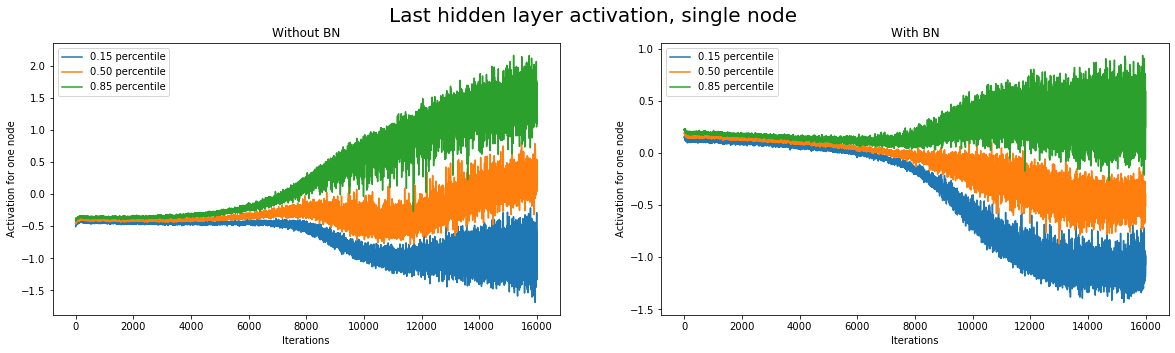

In [47]:
full_activations(epochs_stats_pap,baseline_activation_pap,bn_activation_pap)

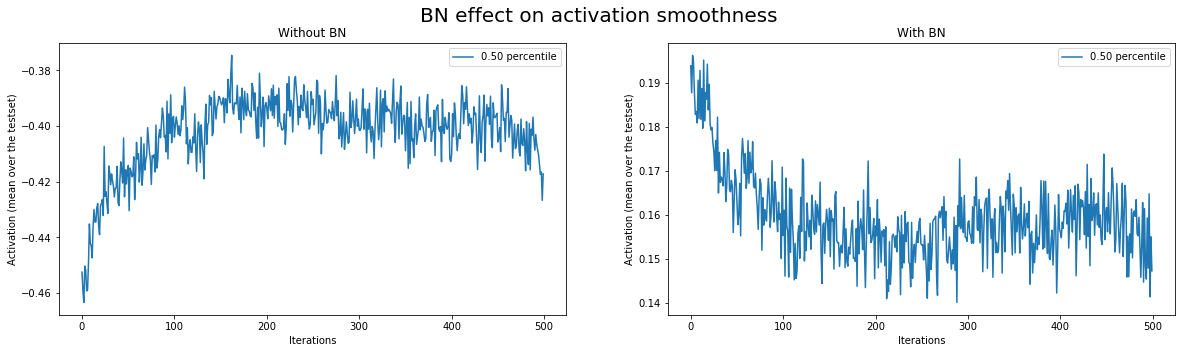

In [48]:
average_activations(epochs_stats_pap,baseline_activation_pap,bn_activation_pap)

In [63]:
# Evaluate accuracy of the models
# vanilla accuracy
acc1 = get_accuracy(model_pap, trainloader)
print(f"Epoch {19} Vanilla Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_pap, testloader)
print(f"Epoch {19} Vanilla Test Accuracy: {acc2 * 100:.02f}%\n")

# batch normalization accuracy
acc1 = get_accuracy(model_bn_pap, trainloader)
print(f"Epoch {19} BN Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_bn_pap, testloader)
print(f"Epoch {19} BN Test Accuracy: {acc2 * 100:.02f}%\n")

Epoch 19 Vanilla Train Accuracy: 77.02%
Epoch 19 Vanilla Test Accuracy: 77.23%

Epoch 19 BN Train Accuracy: 74.80%
Epoch 19 BN Test Accuracy: 75.03%



Paper Architecture, 40 Epochs

In [49]:
baseline_activation_pap_e40 = model_pap_e40.get_model()[5].get_all_activations()
bn_activation_pap_e40 = model_bn_pap_e40.get_model()[5].get_all_activations()

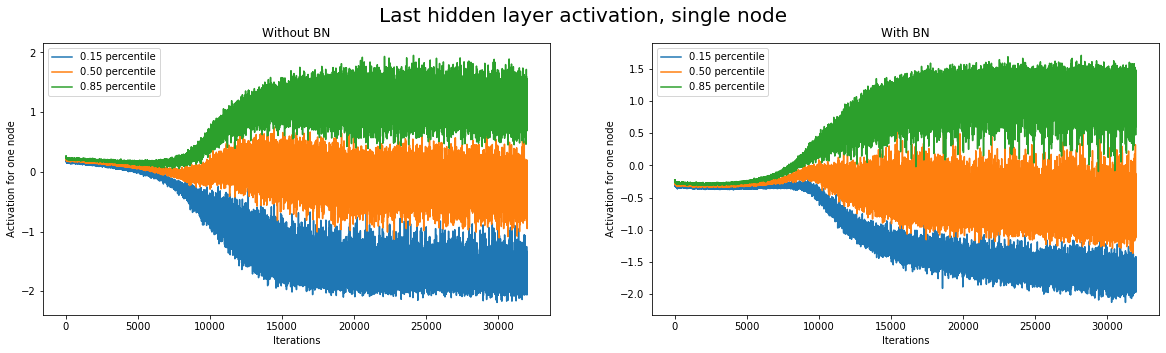

In [50]:
full_activations(epochs_stats_pap_e40,baseline_activation_pap_e40,bn_activation_pap_e40)

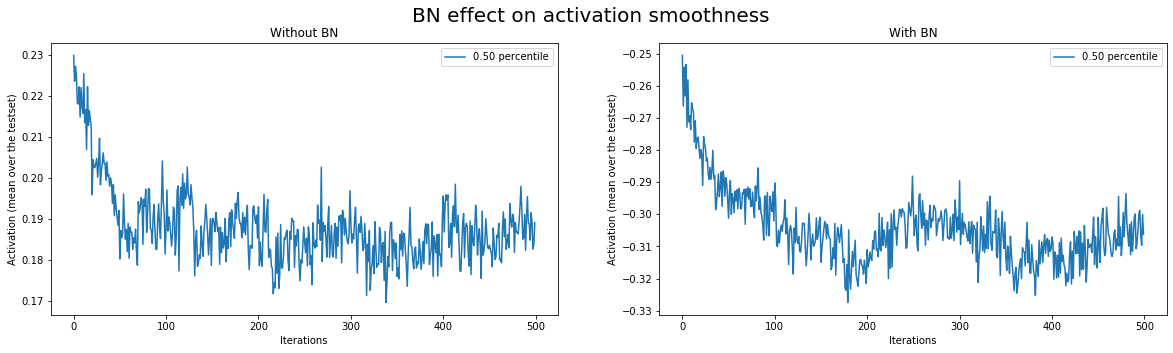

In [51]:
average_activations(epochs_stats_pap_e40,baseline_activation_pap_e40,bn_activation_pap_e40)

In [64]:
# Evaluate accuracy of the models
# vanilla accuracy
acc1 = get_accuracy(model_pap_e40, trainloader)
print(f"Epoch {39} Vanilla Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_pap_e40, testloader)
print(f"Epoch {39} Vanilla Test Accuracy: {acc2 * 100:.02f}%\n")

# batch normalization accuracy
acc1 = get_accuracy(model_bn_pap_e40, trainloader)
print(f"Epoch {39} BN Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_bn_pap_e40, testloader)
print(f"Epoch {39} BN Test Accuracy: {acc2 * 100:.02f}%\n")

Epoch 39 Vanilla Train Accuracy: 88.98%
Epoch 39 Vanilla Test Accuracy: 88.98%

Epoch 39 BN Train Accuracy: 88.44%
Epoch 39 BN Test Accuracy: 88.24%



Paper Architecture, Learning Rate 1e-3

In [52]:
baseline_activation_pap_lr3 = model_pap_lr3.get_model()[5].get_all_activations()
bn_activation_pap_lr3 = model_bn_pap_lr3.get_model()[5].get_all_activations()

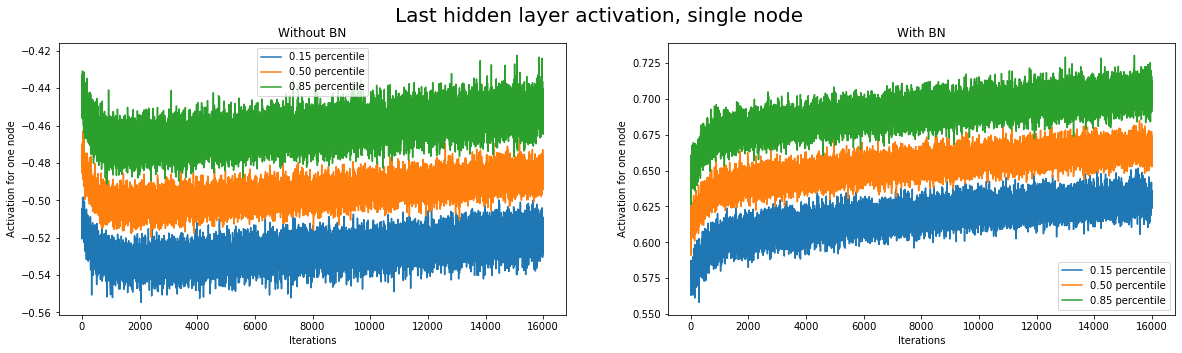

In [53]:
full_activations(epochs_stats_pap_lr3,baseline_activation_pap_lr3,bn_activation_pap_lr3)

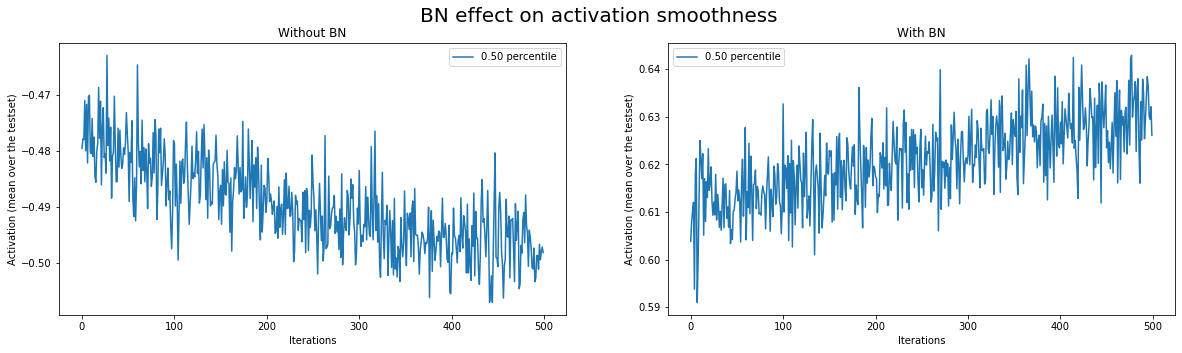

In [54]:
average_activations(epochs_stats_pap_lr3,baseline_activation_pap_lr3,bn_activation_pap_lr3)

In [66]:
# Evaluate accuracy of the models
# vanilla accuracy
acc1 = get_accuracy(model_pap_lr3, trainloader)
print(f"Epoch {19} Vanilla Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_pap_lr3, testloader)
print(f"Epoch {19} Vanilla Test Accuracy: {acc2 * 100:.02f}%\n")

# batch normalization accuracy
acc1 = get_accuracy(model_bn_pap_lr3, trainloader)
print(f"Epoch {19} BN Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_bn_pap_lr3, testloader)
print(f"Epoch {19} BN Test Accuracy: {acc2 * 100:.02f}%\n")

Epoch 19 Vanilla Train Accuracy: 11.17%
Epoch 19 Vanilla Test Accuracy: 11.49%

Epoch 19 BN Train Accuracy: 11.17%
Epoch 19 BN Test Accuracy: 11.50%



Paper Architecture, 40 Epochs, Learning Rate 1e-3

In [55]:
baseline_activation_pap_e40_lr3 = model_pap_e40_lr3.get_model()[5].get_all_activations()
bn_activation_pap_e40_lr3 = model_bn_pap_e40_lr3.get_model()[5].get_all_activations()

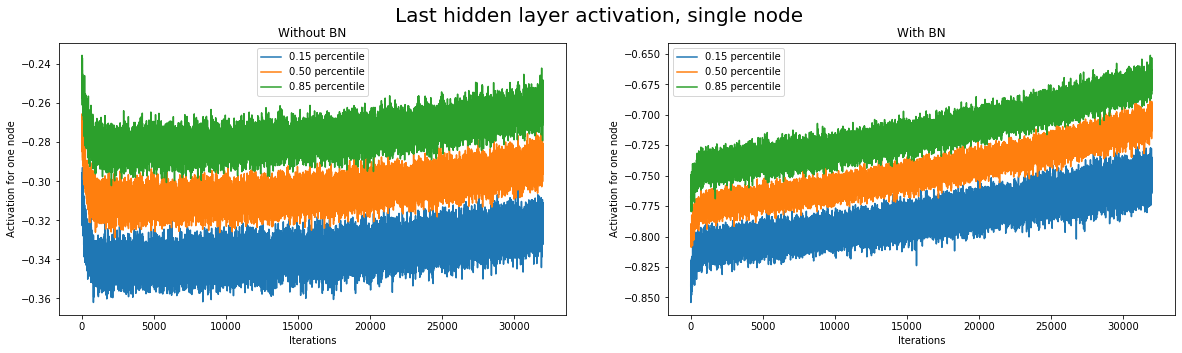

In [56]:
full_activations(epochs_stats_pap_e40_lr3,baseline_activation_pap_e40_lr3,bn_activation_pap_e40_lr3)

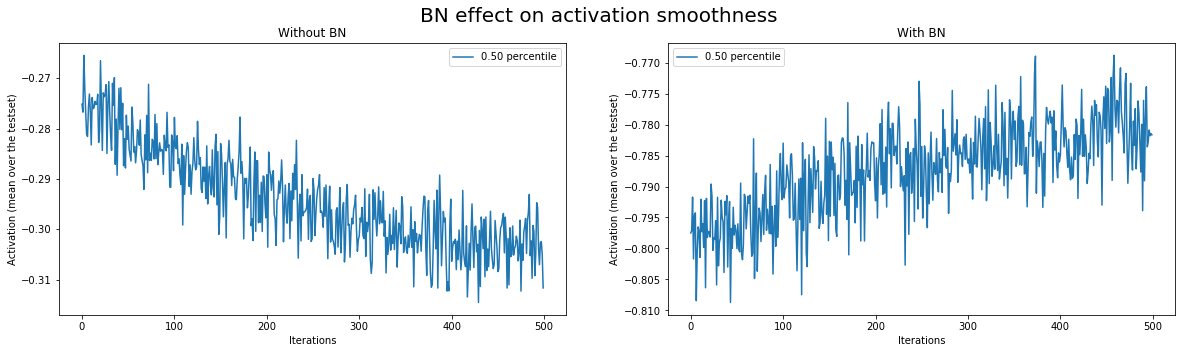

In [57]:
average_activations(epochs_stats_pap_e40_lr3,baseline_activation_pap_e40_lr3,bn_activation_pap_e40_lr3)

In [65]:
# Evaluate accuracy of the models
# vanilla accuracy
acc1 = get_accuracy(model_pap_e40_lr3, trainloader)
print(f"Epoch {39} Vanilla Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_pap_e40_lr3, testloader)
print(f"Epoch {39} Vanilla Test Accuracy: {acc2 * 100:.02f}%\n")

# batch normalization accuracy
acc1 = get_accuracy(model_bn_pap_e40_lr3, trainloader)
print(f"Epoch {39} BN Train Accuracy: {acc1 * 100:.02f}%")
acc2 = get_accuracy(model_bn_pap_e40_lr3, testloader)
print(f"Epoch {39} BN Test Accuracy: {acc2 * 100:.02f}%\n")

Epoch 39 Vanilla Train Accuracy: 11.99%
Epoch 39 Vanilla Test Accuracy: 12.20%

Epoch 39 BN Train Accuracy: 11.69%
Epoch 39 BN Test Accuracy: 11.89%



**TODO: If you make changes to the architecture or training regime, how does this affect the behavior of these last activation values?**

Expectedly with a lower learning rate, the models take more iterations to completely learn.  Note that since the paper architecture takes even longer to learn, using the lower learning rate with the paper architecture causes the models to fail to completely learn the training data.  Notably too, with the paper architecture the difference between the percentiles also significantly decreases to the point where there isn't a significant difference between the vanilla and batch-normalization networks.  As expected too, increasing the number of epochs increases the likelihood of sufficiently learning the training data.  Notably, the increased epoch model was the most successful most using the paper architecture.  In fact the only other paper architecture model which performed better than random was with a simple change of architecture and no parameter change.  This is likely due to the other paper architecture models not being given enough time to train due to the lowered learning rate.

**TODO: How does the accuracy of the models change when you change the architecture, learning rate, or number of iterations?**

Expectedly, the accuracy increases when increasing the number of iterations, increasing the learning rate, or using the notebook architecture.  This is because all of those lead to a greater chance of the model learning the training data.  By increasing the number of iterations you're increasing the amount of time the model has to learn, by increasing the learning rate you're increasing the rate at which the model descends the loss landscape, and the paper architecture is known to be slower.  In fact by choosing the combination of factors to maximimally slow down the model it may fail to learn at all, which can be seen above.